<h1>Classification of normal and abnormal symptoms of the gastrointestinal tract from wireless capsule endoscopy with convolutional neural networks and transformer.</h1>

<strong>Abstract</strong><br><br>
This research originates from the importance of developing models to differentiate images of the digestive system from wireless capsule endoscopy cameras. Motivated by the challenges in diagnosing gastrointestinal diseases using limited camera capabilities, this research aims to develop efficient models capable of distinguishing between normal and abnormal images of the digestive system. Both VGG16 and Vision Transformer models were trained using original and augmented datasets, with Adam and Adamax optimizers. Parameters were kept consistent for comparison. The highest accuracy was achieved by the Vision Transformer model trained with Adamax optimizer on augmented data, reaching 98.15%. Another notable metric, Sensitivity (Recall), peaked with the Vision Transformer model trained with Adam optimizer on the original dataset, scoring 99.82%. In summary, the Vision Transformer model outperformed VGG16 in image separation efficiency.

<h2>Define the Required Variables and Set Initial Values</h2>

In [1]:
select_model = "ViT" if input("Select Model Option to Train and Evaluate.\n1. VGG16 **Default Option** (Enter 1)\n2. Vision Transformer (ViT) (Enter 2)") == "2" else "VGG16" # VGG16 or ViT
select_dataset = "Augmentation" if input("Select Dataset Option to Train and Evaluate Model.\n1. Origianl Dataset **Default Option** (Enter 1)\n2. Augmented Dataset (Enter 2)") == "2" else "Original" # Original or Augmentation

# SGD / Adam / Adadelta / RMSprop / Adamax / AdamW
input_optimizer = input("Select Optimizer Option to Train and Evaluate Model.\n1. SGD **Default Option** (Enter 1)\n2. Adam (Enter 2)\n3. Adadelta (Enter 3)\n4. RMSprop (Enter 4)\n5. Adamax (Enter 5)\n6. AdamW (Enter 6)")

if input_optimizer == "2":
    select_optimizer = "Adam"
if input_optimizer == "3":
    select_optimizer = "Adadelta"
if input_optimizer == "4":
    select_optimizer = "RMSProp"
if input_optimizer == "5":
    select_optimizer = "Adamax"
if input_optimizer == "6":
    select_optimizer = "AdamW"
else:
    select_optimizer = "SGD"

select_seed_number = 254
input_batch_size = 32
input_image_size = 224
input_learning_rate = 0.0001
target_epochs = 50

# Accuracy / Recall / Precision / Specificity / F1-Score
input_target_best_value_mode = input("Select the Best Value Option for Deciding the Model.\n1. Accuracy **Default Option** (Enter 1)\n2. Recall (Enter 2)\n3. Precision (Enter 3)\n4. Specificity (Enter 4)\n5. F1-Score (Enter 5)")

if input_target_best_value_mode == "2":
    target_best_value_mode = "Recall" 
if input_target_best_value_mode == "3":
    target_best_value_mode = "Precision" 
if input_target_best_value_mode == "4":
    target_best_value_mode = "Specificity" 
if input_target_best_value_mode == "5":
    target_best_value_mode = "F1-Score" 
else:
    target_best_value_mode = "Accuracy" 

<h2>Step 1 : Import Library</h2>

In [2]:
import sys

sys_dir = './'

sys.path.append(sys_dir)
sys.path.append('./SourceCode/')

In [3]:
from __future__ import print_function, division

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, SubsetRandomSampler
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime
from typing import List, Tuple

from model_classification_func import train_model, resume_train_model, eval_model, visualize_model
from graph_func import show_databatch, plot_loss_curves, plot_train_validate_score, pred_and_plot_image, plot_confusion_matrix, plot_ROCAUC_curve

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###### Use CPU Only
# device = torch.device('cpu')

use_gpu = torch.cuda.is_available()

####### Use CPU Only
# use_gpu = False

if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [5]:
num_gpus = torch.cuda.device_count()

<h2>Step 2 : Preparing the Dataset</h2>

<h3>2.1 Load Dataset and Image Transformation</h3>

In [6]:
num_worker = os.cpu_count()

# Original Dataset Directory
data_dir = sys_dir + "FinalDataset_Gastrointestinal_Tract_V1"

# Augmentation Dataset Directory
augmented_data_dir = sys_dir + "AugmentationDataset_GIT_V2_(21680)"

img_size = input_image_size

transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])

dataset = ImageFolder(data_dir, transform = transform)

augmented_dataset = ImageFolder(augmented_data_dir, transform = transform)

In [13]:
print(f"Original Dataset Size: {len(dataset)}")

# นับจำนวนรูปภาพในแต่ละคลาส
class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in dataset.classes}

# แสดงผลลัพธ์
for class_name, count in class_counts.items():
    print(f"--> Class: {class_name}, Number of Images: {count}")
    
print("="*50)
    
print(f"Augmented Dataset Size: {len(augmented_dataset)}")

# นับจำนวนรูปภาพในแต่ละคลาส
augmented_class_counts = {class_name: len(os.listdir(os.path.join(augmented_data_dir, class_name))) for class_name in augmented_dataset.classes}

# แสดงผลลัพธ์
for class_name, count in augmented_class_counts.items():
    print(f"--> Class: {class_name}, Number of Images: {count}")

Original Dataset Size: 10840
--> Class: Abnormal, Number of Images: 5420
--> Class: Normal, Number of Images: 5420
Augmented Dataset Size: 21680
--> Class: Abnormal, Number of Images: 10840
--> Class: Normal, Number of Images: 10840


<h3>2.2 Load Dataset into DataLoader</h3>

In [14]:
seed_number = select_seed_number

# คำนวณจำนวนรูปภาพทั้งหมดในแต่ละคลาส
class_counts = {}
for _, label in dataset.samples:
    class_counts[label] = class_counts.get(label, 0) + 1

# ลองใช้การสุ่มแบบจำนวนคลาสที่เท่ากัน
train_indices = []
validation_indices = []
test_indices = []

print("Original Dataset\n")

for label in range(len(class_counts)):
    label_indices = [idx for idx, (_, l) in enumerate(dataset.samples) if l == label]
    class_train_size = int(0.8 * len(label_indices))
    class_validation_size = class_test_size = int((len(label_indices) - class_train_size) * 0.5)
    
    print("Class ", "Abnormal" if label == 0 else "Normal", " Index Report")
    
    print("Before shuffle: ", label_indices[:5], "...")
    
    # Random
    random.seed(seed_number)
    label_indices = random.sample(label_indices, len(label_indices))
    
    print("After shuffle: ", label_indices[:5], "...\n")

    train_indices.extend(label_indices[:class_train_size])
    validation_indices.extend(label_indices[class_train_size:class_train_size + class_validation_size])
    test_indices.extend(label_indices[class_train_size + class_validation_size:])

Original Dataset

Class  Abnormal  Index Report
Before shuffle:  [0, 1, 2, 3, 4] ...
After shuffle:  [3070, 4104, 2055, 3359, 2784] ...

Class  Normal  Index Report
Before shuffle:  [5420, 5421, 5422, 5423, 5424] ...
After shuffle:  [8490, 9524, 7475, 8779, 8204] ...



In [15]:
# คำนวณจำนวนรูปภาพทั้งหมดในแต่ละคลาส
augmented_class_counts = {}
for _, label in augmented_dataset.samples:
    augmented_class_counts[label] = augmented_class_counts.get(label, 0) + 1

# ลองใช้การสุ่มแบบจำนวนคลาสที่เท่ากัน
augmented_train_indices = []
augmented_validation_indices = []
augmented_test_indices = []

print("Augmented Dataset\n")

for label in range(len(augmented_class_counts)):
    label_indices = [idx for idx, (_, l) in enumerate(augmented_dataset.samples) if l == label]
    class_train_size = int(0.8 * len(label_indices))
    class_validation_size = class_test_size = int((len(label_indices) - class_train_size) * 0.5)
    
    print("Class ", "Abnormal" if label == 0 else "Normal", " Index Report")
    
    print("Before shuffle: ", label_indices[:5], "...")
    
    # Random
    random.seed(seed_number)
    label_indices = random.sample(label_indices, len(label_indices))
    
    print("After shuffle: ", label_indices[:5], "...\n")

    augmented_train_indices.extend(label_indices[:class_train_size])
    augmented_validation_indices.extend(label_indices[class_train_size:class_train_size + class_validation_size])
    augmented_test_indices.extend(label_indices[class_train_size + class_validation_size:])

Augmented Dataset

Class  Abnormal  Index Report
Before shuffle:  [0, 1, 2, 3, 4] ...
After shuffle:  [6140, 8208, 4111, 6718, 5569] ...

Class  Normal  Index Report
Before shuffle:  [10840, 10841, 10842, 10843, 10844] ...
After shuffle:  [16980, 19048, 14951, 17558, 16409] ...



In [16]:
# # หลังจาก random_split
# train_set_samples = [train_set.dataset.samples[index] for index in train_set.indices]
# validation_set_samples = [validation_set.dataset.samples[index] for index in validation_set.indices]
# test_set_samples = [test_set.dataset.samples[index] for index in test_set.indices]

def dataset_class_count_report(title, class_counts, dataset, train_indices, validation_indices, test_indices):
    train_class_counts = {label: 0 for label in class_counts}
    validation_class_counts = {label: 0 for label in class_counts}
    test_class_counts = {label: 0 for label in class_counts}

    # Train Set
    for idx in train_indices:
        label = dataset.targets[idx]
        train_class_counts[label] += 1

    # Validation Set
    for idx in validation_indices:
        label = dataset.targets[idx]
        validation_class_counts[label] += 1

    # Test Set
    for idx in test_indices:
        label = dataset.targets[idx]
        test_class_counts[label] += 1    

    print("\n", title, "\n")    

    print("Train Class Counts:", train_class_counts, " Total: ", len(train_indices))
    print("Validation Class Counts:", validation_class_counts, " Total: ", len(validation_indices))
    print("Test Class Counts:", test_class_counts, " Total: ", len(test_indices))

dataset_class_count_report("Original Dataset Class Count Report", class_counts, dataset, train_indices, validation_indices, test_indices)
dataset_class_count_report("Augmented Dataset Class Count Report", augmented_class_counts, augmented_dataset, augmented_train_indices, augmented_validation_indices, augmented_test_indices)


 Original Dataset Class Count Report 

Train Class Counts: {0: 4336, 1: 4336}  Total:  8672
Validation Class Counts: {0: 542, 1: 542}  Total:  1084
Test Class Counts: {0: 542, 1: 542}  Total:  1084

 Augmented Dataset Class Count Report 

Train Class Counts: {0: 8672, 1: 8672}  Total:  17344
Validation Class Counts: {0: 1084, 1: 1084}  Total:  2168
Test Class Counts: {0: 1084, 1: 1084}  Total:  2168


In [17]:
batch_size = input_batch_size

# Dataset
class_names = dataset.classes
class_index = dataset.class_to_idx

augmented_class_names = augmented_dataset.classes
augmented_class_index = augmented_dataset.class_to_idx

if select_dataset == "Original":
    
    # ORIGINAL DATALOADER
    train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices), num_workers=num_worker)
    val_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(validation_indices), num_workers=num_worker)
    test_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices), num_workers=num_worker)

    train_data = Subset(dataset, train_indices)
    val_data = Subset(dataset, validation_indices)
    test_data = Subset(dataset, test_indices)

    train_size = len(train_indices)
    val_size = len(validation_indices)
    test_size = len(test_indices)

elif select_dataset == "Augmentation":
    
    # AUGMENTED DATALOADER
    train_dl = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(augmented_train_indices), num_workers=num_worker)
    val_dl = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(augmented_validation_indices), num_workers=num_worker)
    test_dl = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(augmented_test_indices), num_workers=num_worker)

    train_data = Subset(augmented_dataset, augmented_train_indices)
    val_data = Subset(augmented_dataset, augmented_validation_indices)
    test_data = Subset(augmented_dataset, augmented_test_indices)

    train_size = len(augmented_train_indices)
    val_size = len(augmented_validation_indices)
    test_size = len(augmented_test_indices)

<h2>Step 3 : Visualize Data</h2>

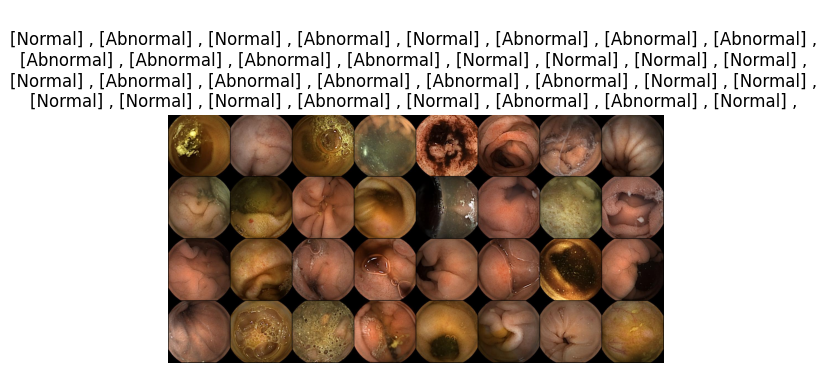

In [18]:
# Get a batch of training data
inputs, classes = next(iter(train_dl))

show_databatch(inputs, classes, class_names, batch_size)

<h2>Step 4 : Load the Model from Pytorch and Adjust the Model Layers.</h2>

<h3>for VGG16 Model</h3>

In [19]:
if select_model == "VGG16":

    # Load the pretrained model from pytorch
    vgg16 = models.vgg16_bn()
    vgg16.load_state_dict(torch.load(sys_dir + "checkpoints/vgg16_bn-6c64b313.pth"))
    if use_gpu:
        vgg16.to(device)
    print(vgg16.classifier[6].out_features) # 1000 

    # Freeze training for all layers
    for param in vgg16.features.parameters():
        param.require_grad = False

    # Newly created modules have require_grad=True by default
    num_features = vgg16.classifier[6].in_features
    features = list(vgg16.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
    vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
    print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [21]:
if select_model == "VGG16":

    # !pip install torchsummary
    # !pip install torchsummaryX

    from torchinfo import summary
    # from torchsummary import summary as t_summary
    # from torchsummaryX import summary as t_summaryX

    summary(vgg16, (batch_size, 3, 224, 224))
    # t_summary(vgg16, (3, 224, 224))
    # t_summaryX(vgg16, torch.zeros(batch_size, 3, 224, 224).to(device))

<h3>for ViT Model</h3>

In [20]:
if select_model == "ViT":

    from collections import OrderedDict

    # Load the pretrained model from pytorch
    vit_b_16 = models.vit_b_16()
    vit_b_16.load_state_dict(torch.load(sys_dir + "checkpoints/vit_b_16-c867db91.pth"))
    if use_gpu:
        vit_b_16.to(device)
    print(vit_b_16.heads[0].out_features) # 1000 

    # vit_b_16.encoder.parameters()

    # # Freeze training for all layers
    for param in vit_b_16.encoder.parameters():
        param.require_grad = False

    # # Newly created modules have require_grad=True by default
    num_features = vit_b_16.heads[0].in_features
    features = list(vit_b_16.heads.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
    vit_b_16.heads = nn.Sequential(OrderedDict([('head', *features)])) # Replace the model classifier
    print(vit_b_16)

In [22]:
if select_model == "ViT":

    from prettytable import PrettyTable

    def count_parameters(model):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        return total_params

    count_parameters(vit_b_16)

<h2>Step 5 : Setup Hyperparameter</h2>

In [23]:
learning_rate = input_learning_rate

# LOSS FUNCTION
criterion = nn.CrossEntropyLoss()

# SGD OPTIMIZER
if select_optimizer == "SGD":
    if select_model == "VGG16":
        optimizer_ft = optim.SGD(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.SGD(vit_b_16.parameters(), lr=learning_rate)

# ADAM OPTIMIZER
if select_optimizer == "Adam":
    if select_model == "VGG16":
        optimizer_ft = optim.Adam(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.Adam(vit_b_16.parameters(), lr=learning_rate)

# ADAGRAD OPTIMIZER
if select_optimizer == "Adagrad":
    if select_model == "VGG16":
        optimizer_ft = optim.Adagrad(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.Adagrad(vit_b_16.parameters(), lr=learning_rate)

# ADADELTA OPTIMIZER
if select_optimizer == "Adadelta":
    if select_model == "VGG16":
        optimizer_ft = optim.Adadelta(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.Adadelta(vit_b_16.parameters(), lr=learning_rate)

# RMSprop OPTIMIZER
if select_optimizer == "RMSprop":
    if select_model == "VGG16":
        optimizer_ft = optim.RMSprop(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.RMSprop(vit_b_16.parameters(), lr=learning_rate)

# ADAMAX OPTIMIZER
if select_optimizer == "Adamax":
    if select_model == "VGG16":
        optimizer_ft = optim.Adamax(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.Adamax(vit_b_16.parameters(), lr=learning_rate)

# ADAMAW OPTIMIZER
if select_optimizer == "AdamW":
    if select_model == "VGG16":
        optimizer_ft = optim.AdamW(vgg16.parameters(), lr=learning_rate)
    elif select_model == "ViT":
        optimizer_ft = optim.AdamW(vit_b_16.parameters(), lr=learning_rate)

# LEARNING RATE SCHEDULER
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<h2>Step 6 : Train Model</h2>

<h3>for VGG16 Model</h3>

In [24]:
if select_model == "VGG16":

    # If you want to train the model for more epochs, set this to True after the first run
    resume_training = False
    resume_path_model = ""

    if resume_training:
        # Rename the path and file name of the model
        input_model = torch.load(f"{resume_path_model}")

        vgg16.load_state_dict(input_model['model_state_dict'])
        if use_gpu:
            vgg16.to(device)
        optimizer_ft.load_state_dict(input_model['optimizer_state_dict'])

        epochs = input_model['epoch']
        criterion = input_model['loss']
        result_acc_loss = input_model['result_acc_loss']

In [25]:
if select_model == "VGG16":

    if torch.cuda.is_available():
        if num_gpus > 1:
        #         print(f'Number of available GPUs: {num_gpus}')
                # นำรหัสไปและวงล้อรอบโมเดลด้วย DataParallel
                vgg16 = nn.DataParallel(vgg16)
        vgg16 = vgg16.cuda()

In [26]:
if select_model == "VGG16":
    epochs = target_epochs #Adjust Epochs Here
    select_best_value = target_best_value_mode

    if resume_training:
        # If you want to train the model for more epochs. Run the code below.
        vgg16, result_value, best_num_epoch = resume_train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                                                train_data, val_data, train_dl, val_dl, device, result_acc_loss, select_best_value, use_gpu, num_epochs=epochs)
    else:
        # If you train the new model. Run the code below.
        vgg16, result_value, best_num_epoch = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                                        train_data, val_data, train_dl, val_dl, device, select_best_value, use_gpu, num_epochs=epochs)

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    model_name = f"VGG16_Norm_Abnorm_GastrointestinalTract_Model_{dt_string}"

    try:
        os.mkdir("./Result")
    except:
        pass

    path_model = f"./Result/VGG16_model_{len(result_value['train_acc'])}ep_{dt_string}"

    os.mkdir(path_model)
    torch.save({
                'epoch': len(result_value['train_acc']),
                'model_state_dict': vgg16.state_dict(),
                'optimizer_state_dict': optimizer_ft.state_dict(),
                'loss': criterion,
                'result_acc_loss': result_value,
                }, f'{path_model}/{model_name}.pt')

Epoch 1/50
----------
Training batch 541/542 (99.82%)
Validation batch 67/68 (98.53%)
Epoch 1 result: 

Sensitivity (Recall) (train): 0.8644
Precision (train): 0.8451
Specificity (train): 0.8416
F1 Score (train): 0.8546
Avg Loss (train): 0.0104
ACCURACY (train): 0.8530

Sensitivity (Recall) (val): 0.8773
Precision (val): 0.8483
Specificity (val): 0.8432
F1 Score (val): 0.8626
Avg Loss (val): 0.0105
ACCURACY (val): 0.8602
----------

Epoch 2/50
----------
Training batch 541/542 (99.82%)
Validation batch 67/68 (98.53%)
Epoch 2 result: 

Sensitivity (Recall) (train): 0.9572
Precision (train): 0.9461
Specificity (train): 0.9455
F1 Score (train): 0.9516
Avg Loss (train): 0.0040
ACCURACY (train): 0.9513

Sensitivity (Recall) (val): 0.8967
Precision (val): 0.8365
Specificity (val): 0.8247
F1 Score (val): 0.8655
Avg Loss (val): 0.0099
ACCURACY (val): 0.8607
----------

Epoch 3/50
----------
Training batch 541/542 (99.82%)
Validation batch 67/68 (98.53%)
Epoch 3 result: 

Sensitivity (Recall) (

<h3>for ViT Model</h3>

In [27]:
if select_model == "ViT":

    # If you want to train the model for more epochs, set this to True after the first run
    resume_training = False
    resume_path_model = ""

    if resume_training:
        # Rename the path and file name of the models
        input_model = torch.load(f"{resume_path_model}")

        vit_b_16.load_state_dict(input_model['model_state_dict'])
        if use_gpu:
            vit_b_16.to(device)
        optimizer_ft.load_state_dict(input_model['optimizer_state_dict'])

        epochs = input_model['epoch']
        criterion = input_model['loss']
        result_acc_loss = input_model['result_acc_loss']

In [28]:
if select_model == "ViT":

    if torch.cuda.is_available():
        if num_gpus > 1:
        #         print(f'Number of available GPUs: {num_gpus}')
                # นำรหัสไปและวงล้อรอบโมเดลด้วย DataParallel
                vit_b_16 = nn.DataParallel(vit_b_16)
        vit_b_16 = vit_b_16.cuda()

In [29]:
if select_model == "ViT":

    epochs = target_epochs #Adjust Epochs Here
    select_best_value = target_best_value_mode

    if resume_training:
        # If you want to train the model for more epochs. Run the code below.
        vit_b_16, result_value, best_num_epoch = resume_train_model(vit_b_16, criterion, optimizer_ft, exp_lr_scheduler, 
                                                    train_data, val_data, train_dl, val_dl, device, result_acc_loss, select_best_value, use_gpu, num_epochs=epochs)
    else:
        # If you train the new model. Run the code below.
        vit_b_16, result_value, best_num_epoch = train_model(vit_b_16, criterion, optimizer_ft, exp_lr_scheduler, 
                                             train_data, val_data, train_dl, val_dl, device, select_best_value, use_gpu, num_epochs=epochs)

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    model_name = f"ViT_B_16_Norm_Abnorm_GastrointestinalTract_Model_{dt_string}"

    try:
        os.mkdir("./Result")
    except:
        pass

    path_model = f"./Result/vit_model_{len(result_value['train_acc'])}ep_{dt_string}"

    os.mkdir(path_model)
    torch.save({
                'epoch': len(result_value['train_acc']),
                'model_state_dict': vit_b_16.state_dict(),
                'optimizer_state_dict': optimizer_ft.state_dict(),
                'loss': criterion,
                'result_acc_loss': result_value,
                }, f'{path_model}/{model_name}.pt')

<h3>Accuracy and Loss Graph (Training and Validation)</h3>

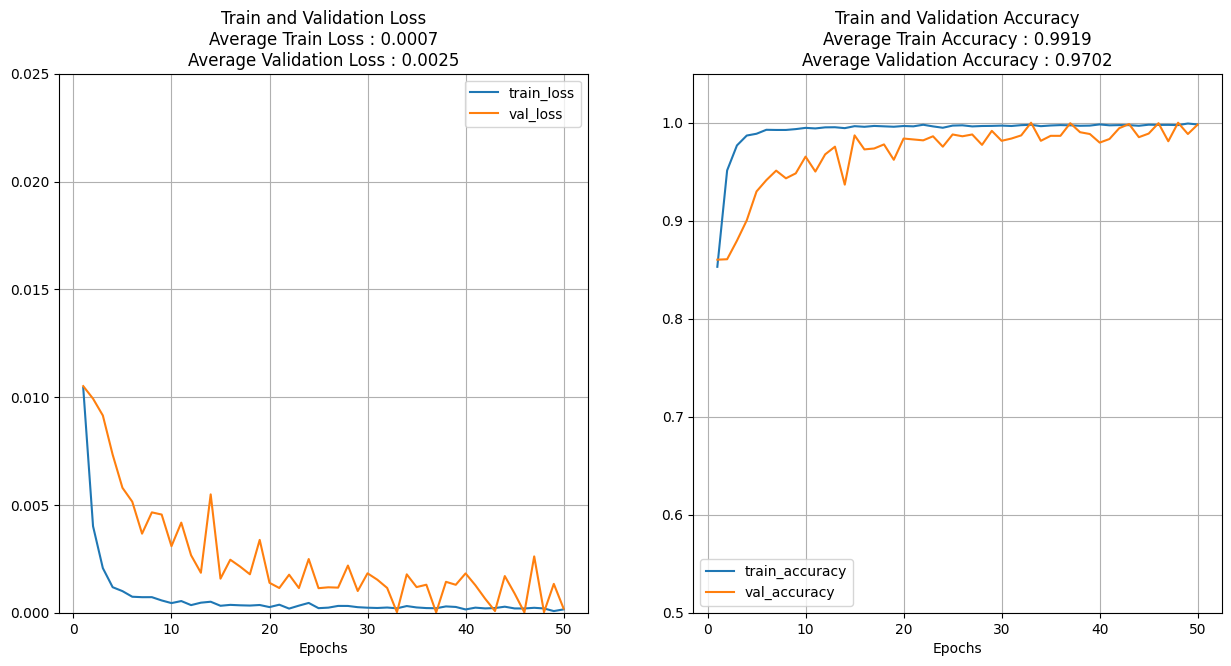

In [30]:
plot_loss_curves(result_value, now, path_model)

<h3>Evaluate Scoring Graph (Training and Validation)</h3>

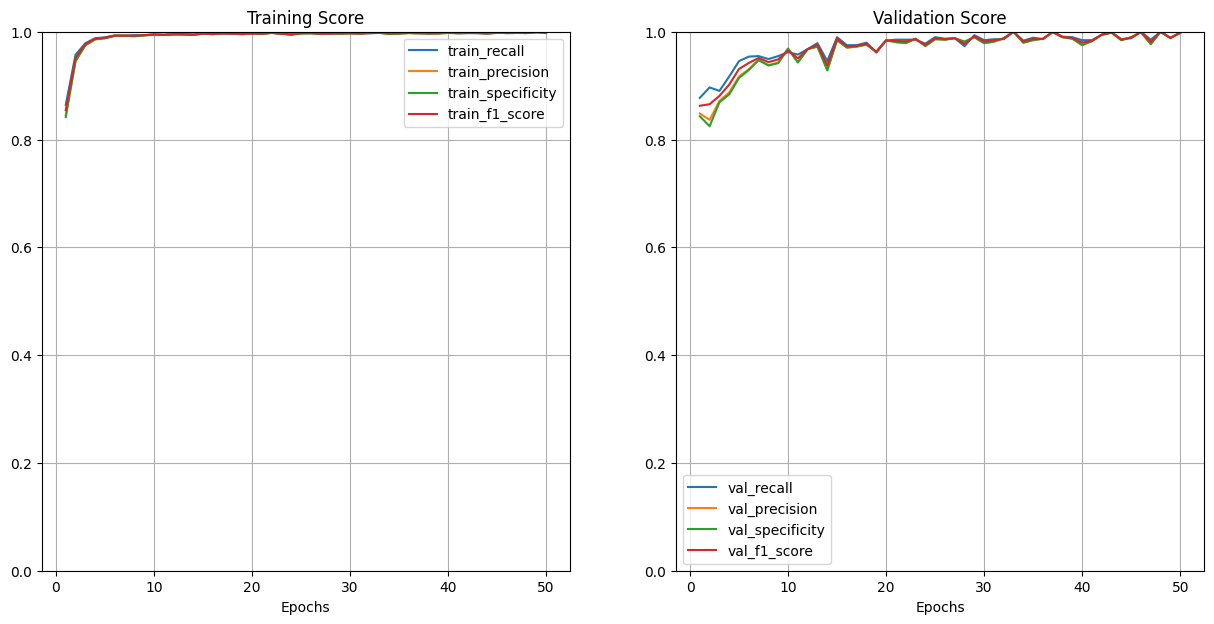

In [31]:
plot_train_validate_score(result_value, now, path_model)

<h3>Confusion Matrix (Training and Validation)</h3>

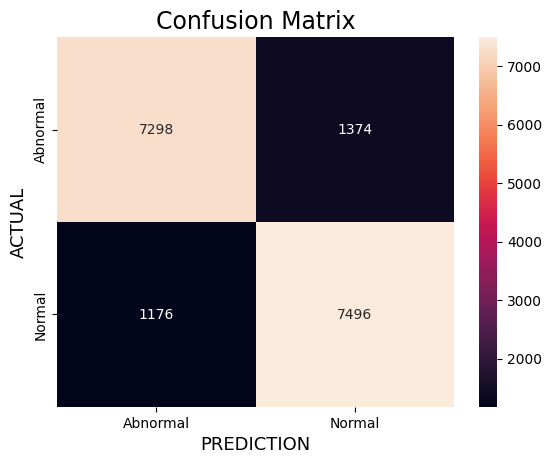

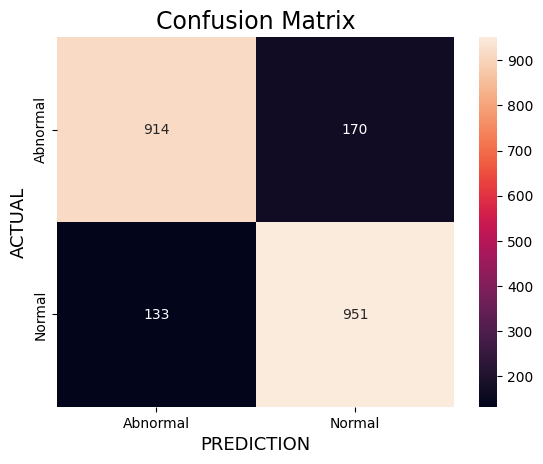

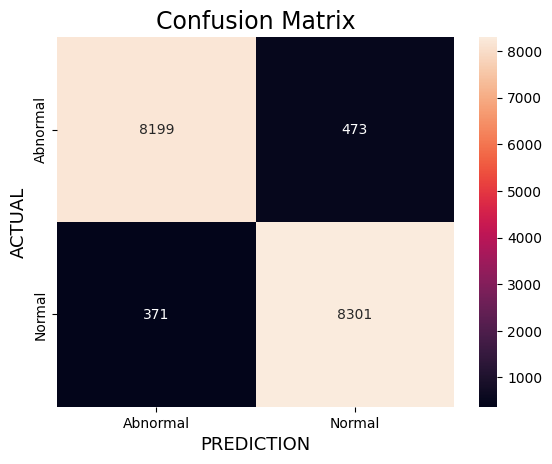

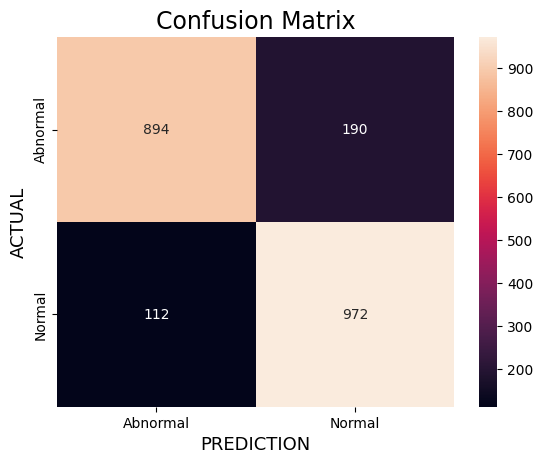

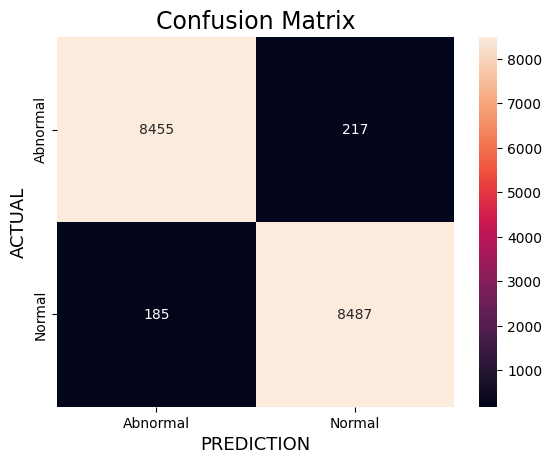

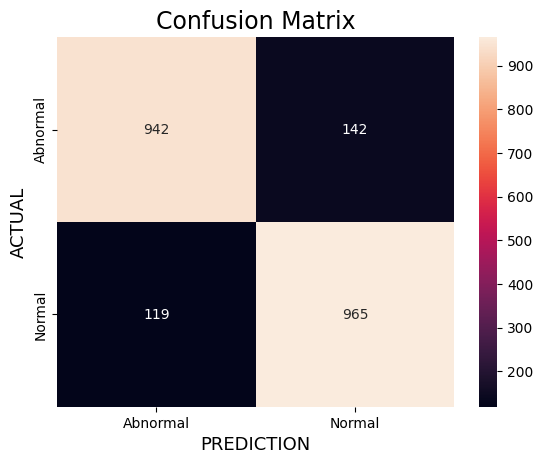

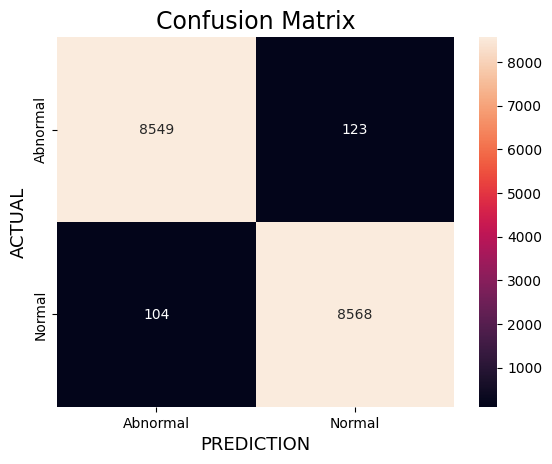

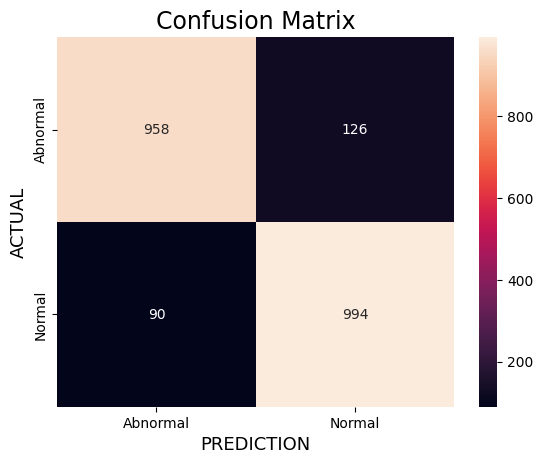

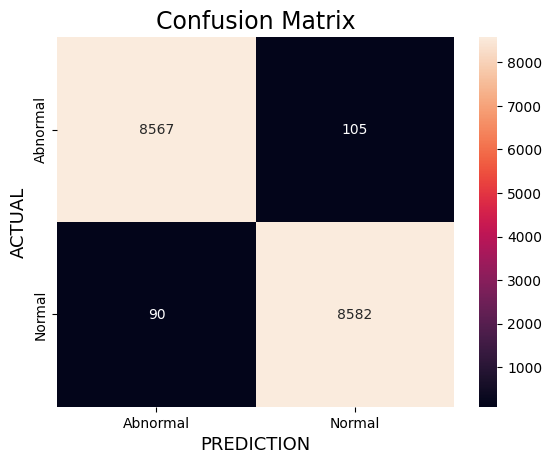

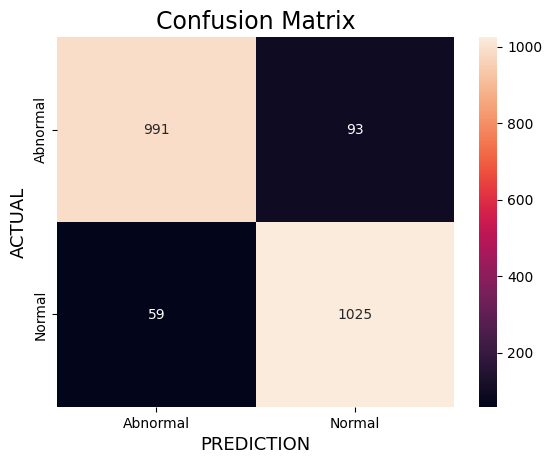

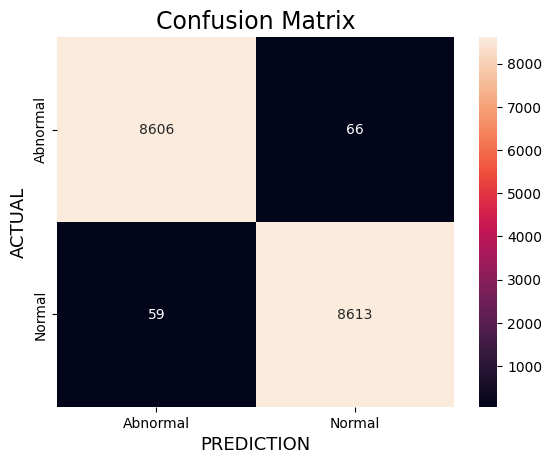

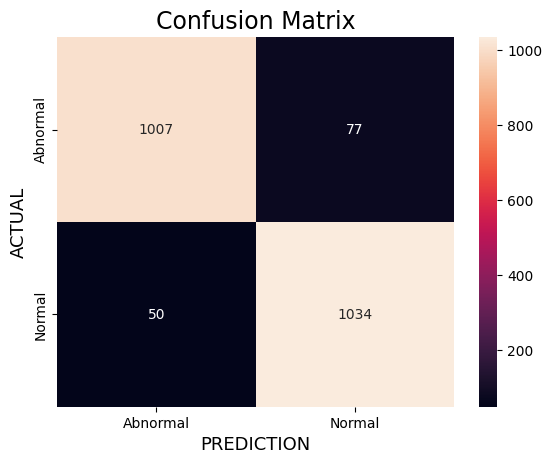

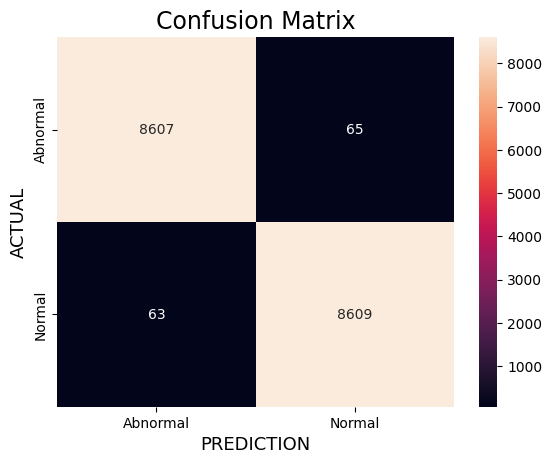

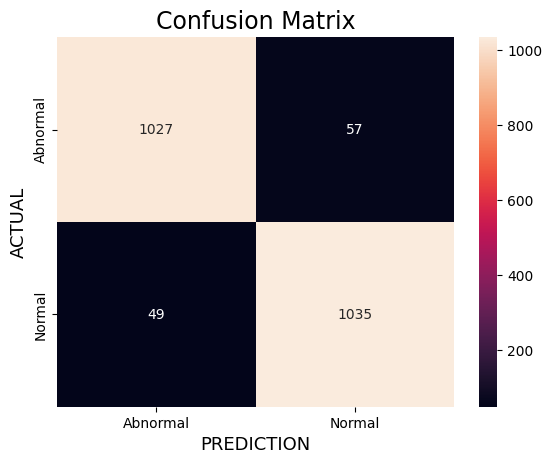

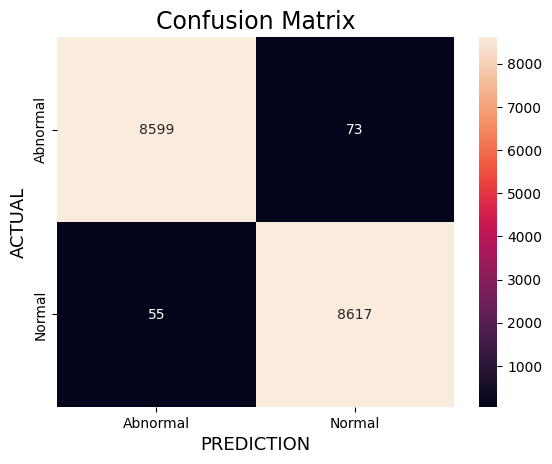

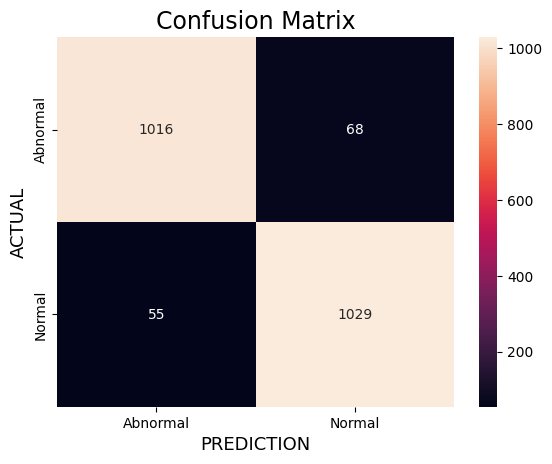

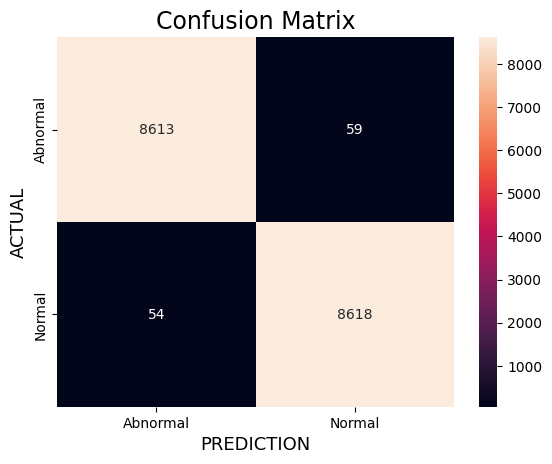

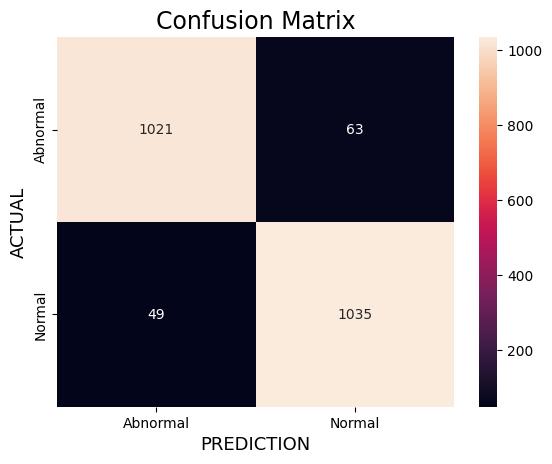

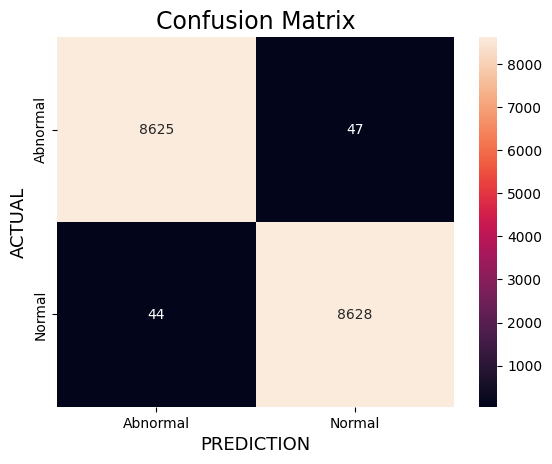

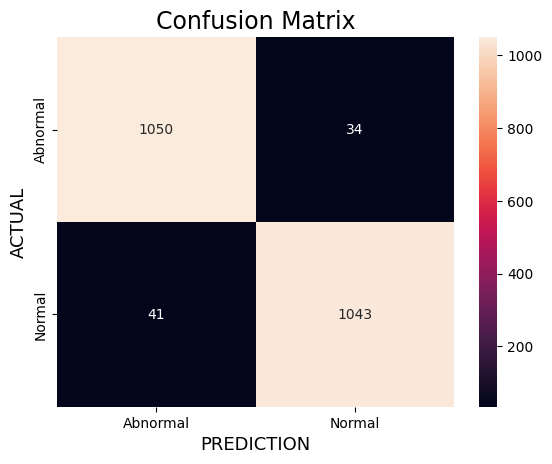

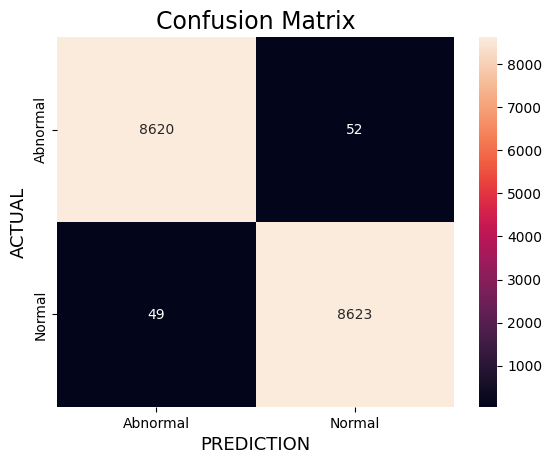

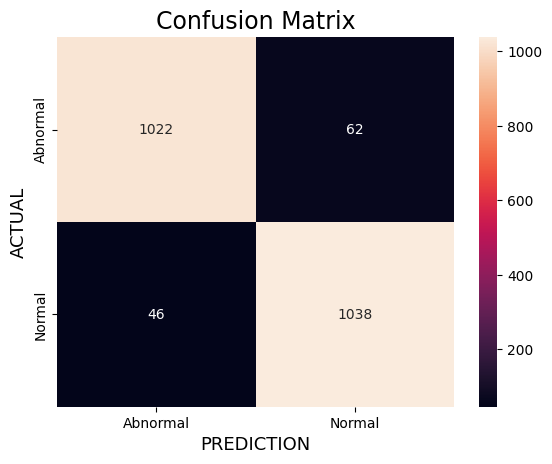

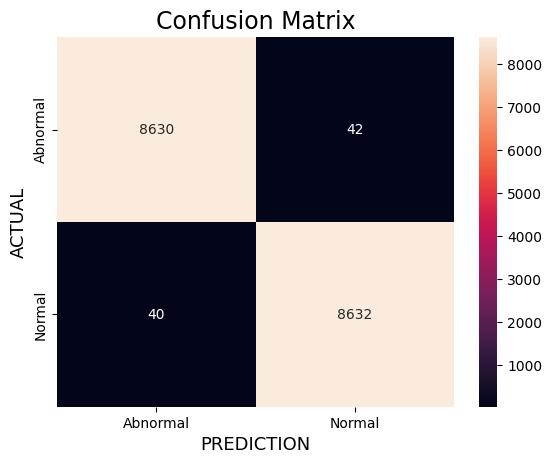

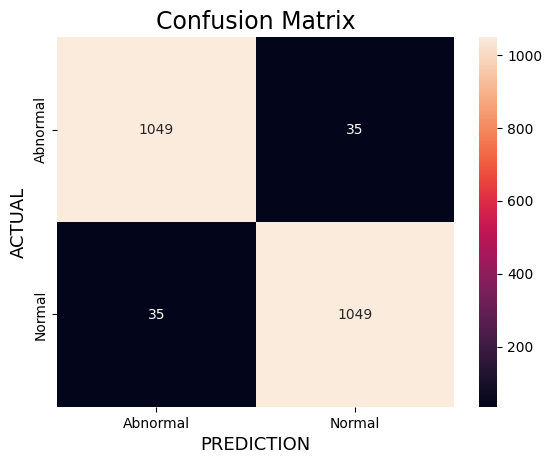

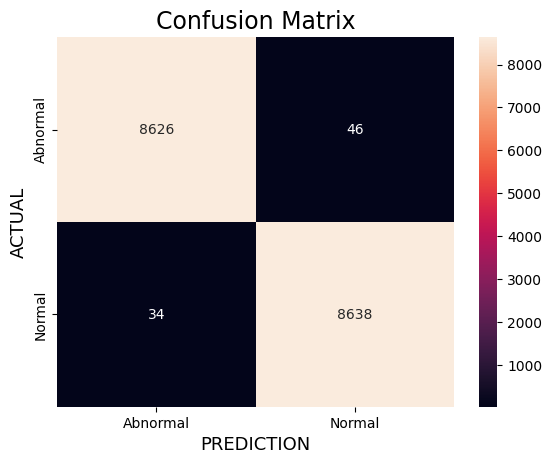

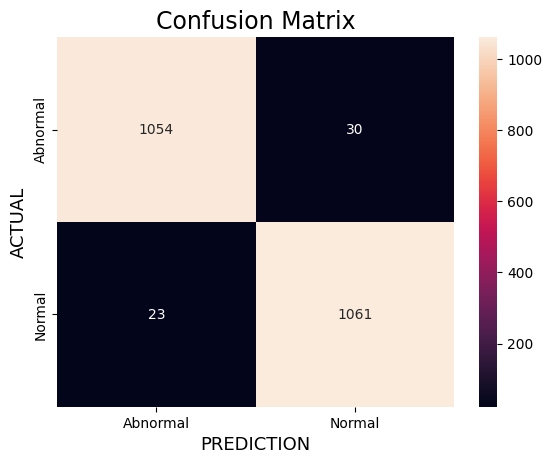

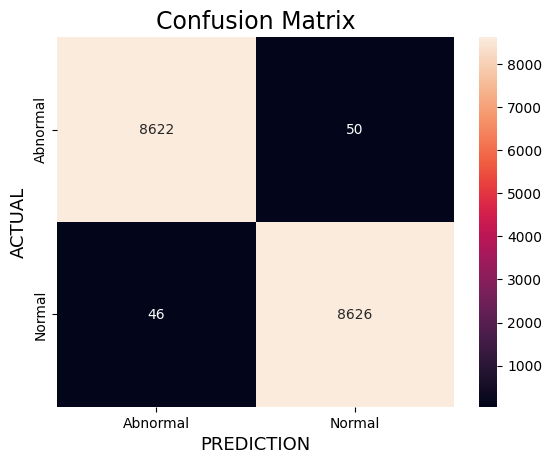

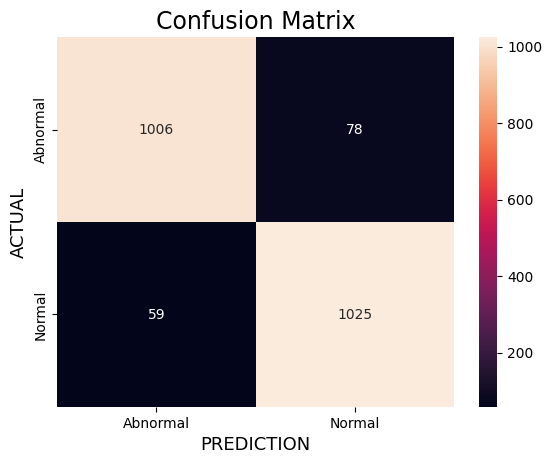

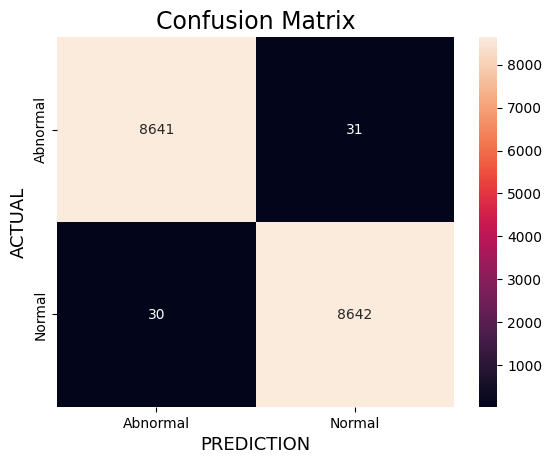

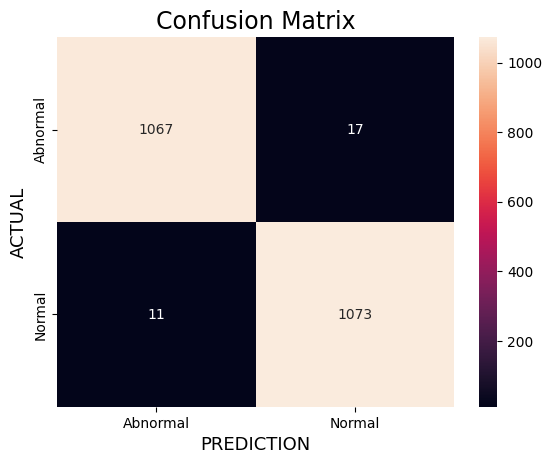

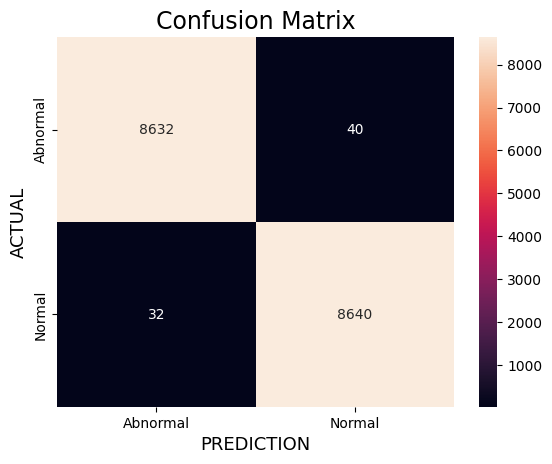

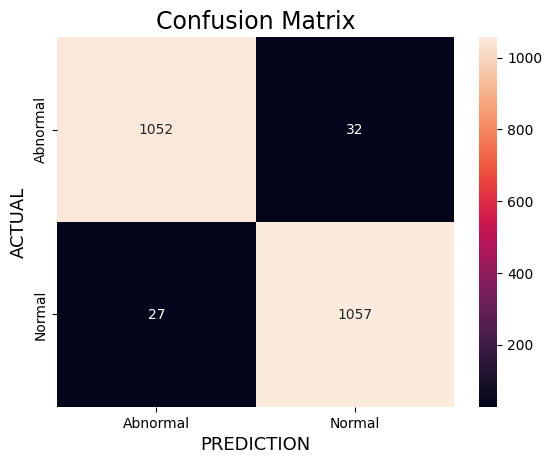

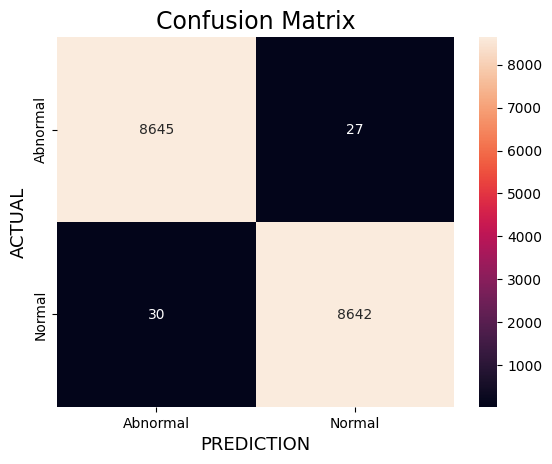

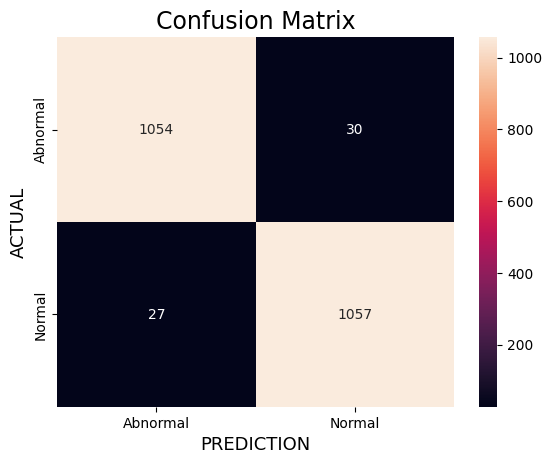

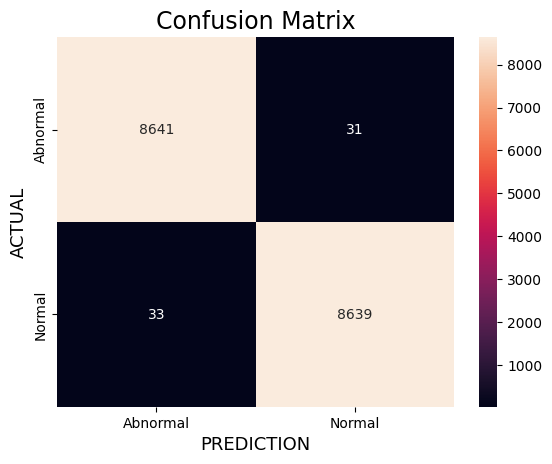

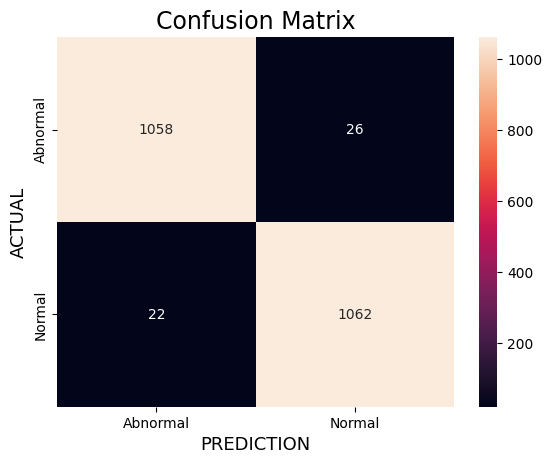

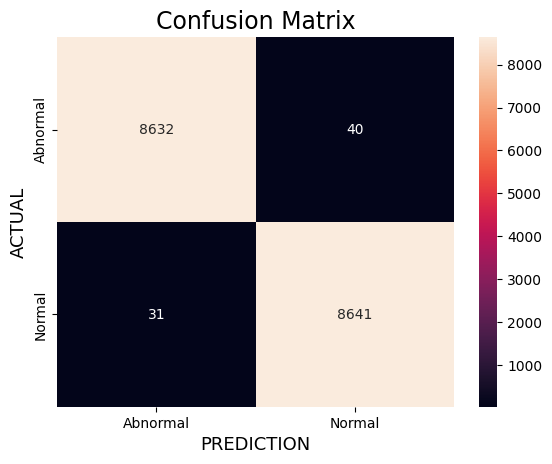

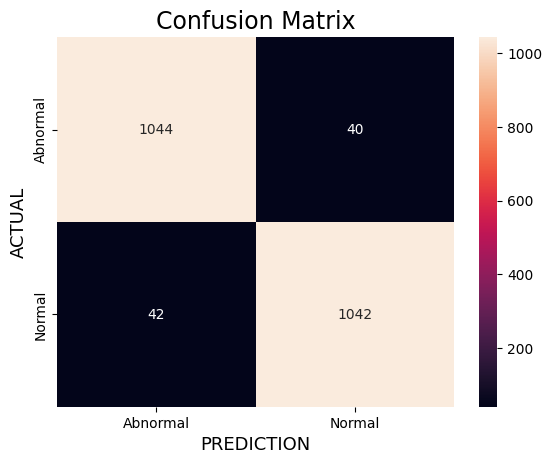

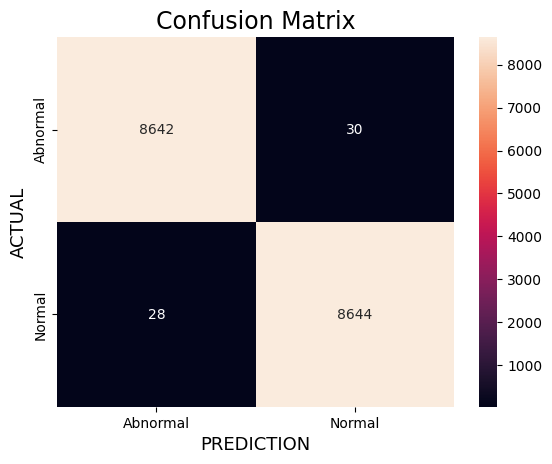

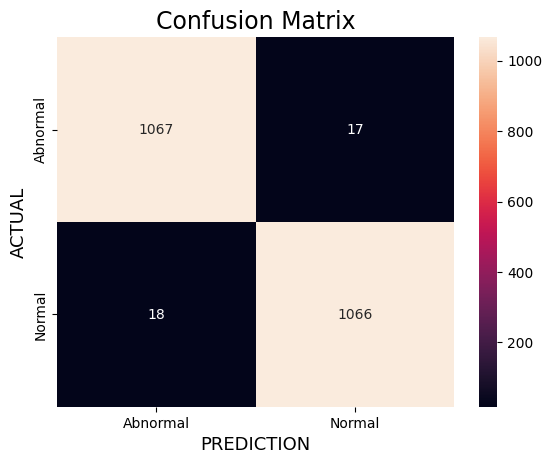

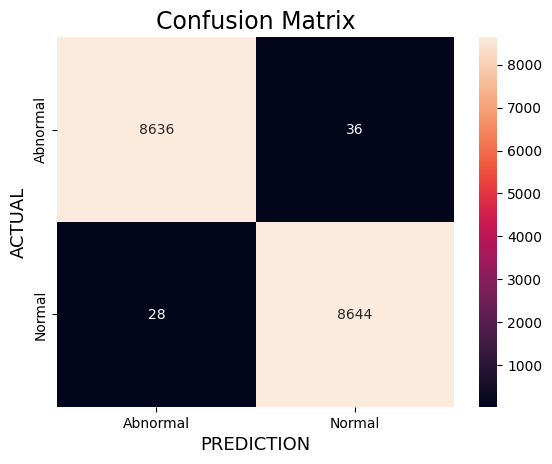

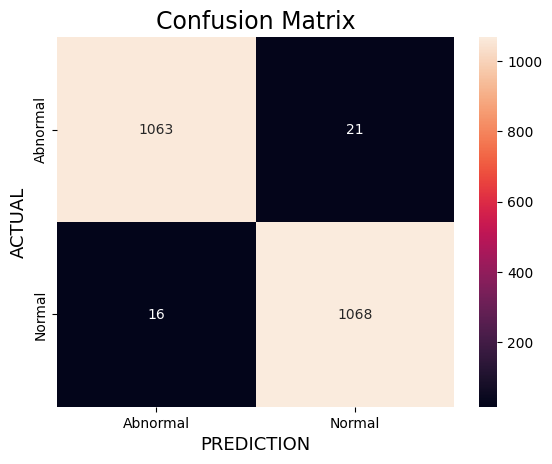

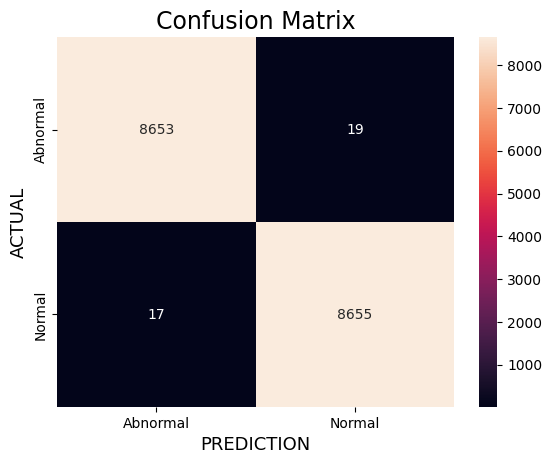

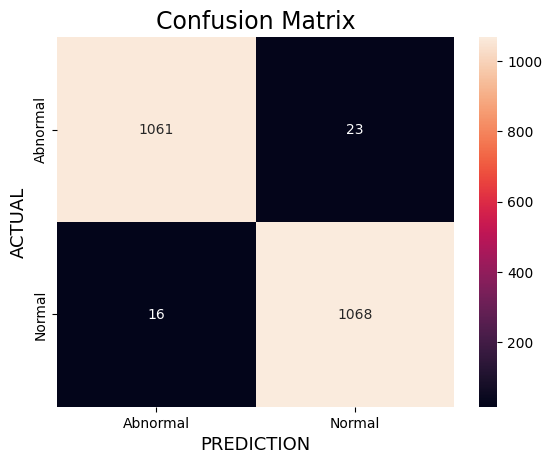

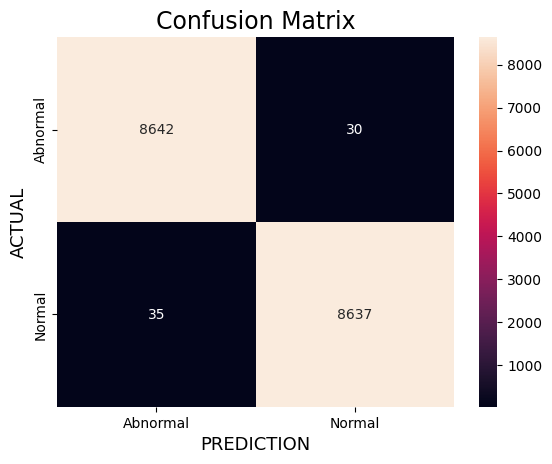

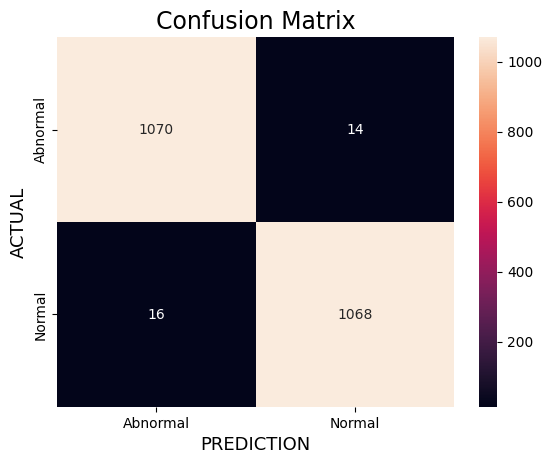

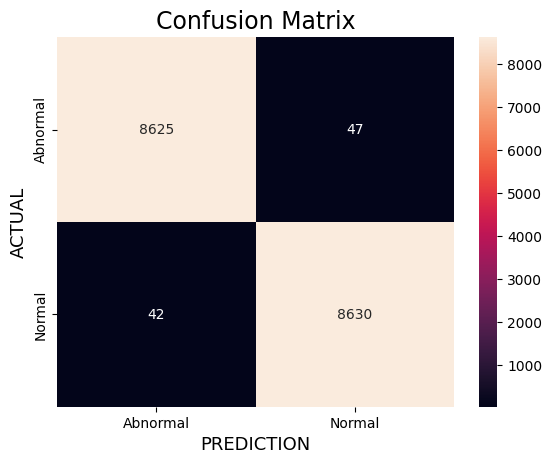

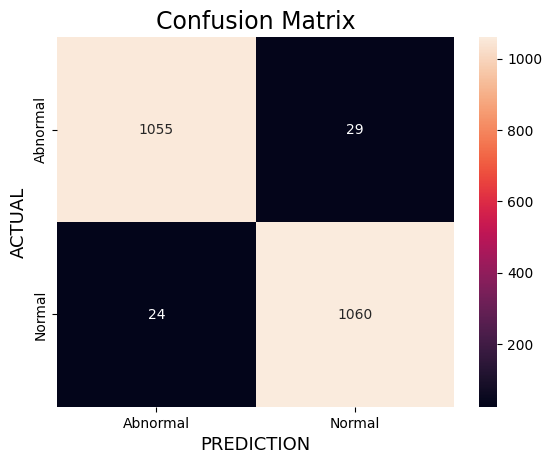

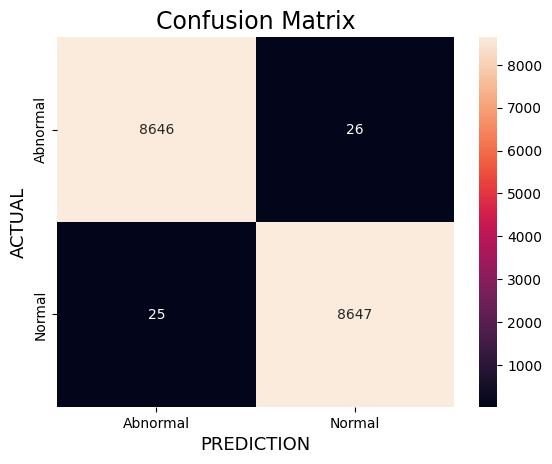

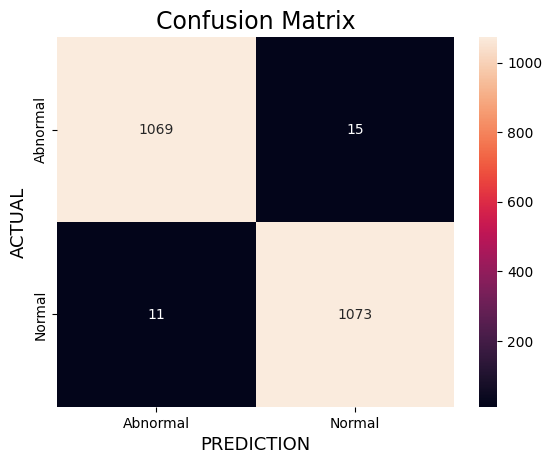

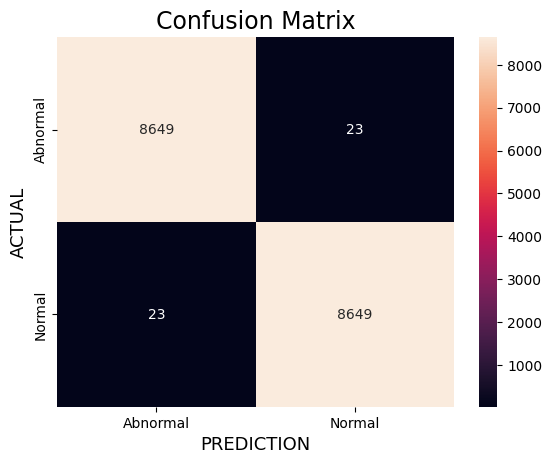

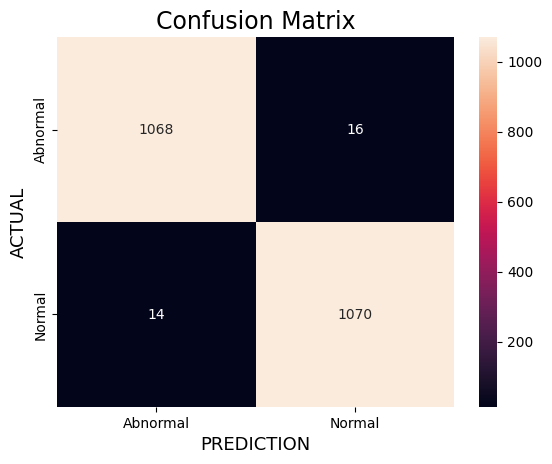

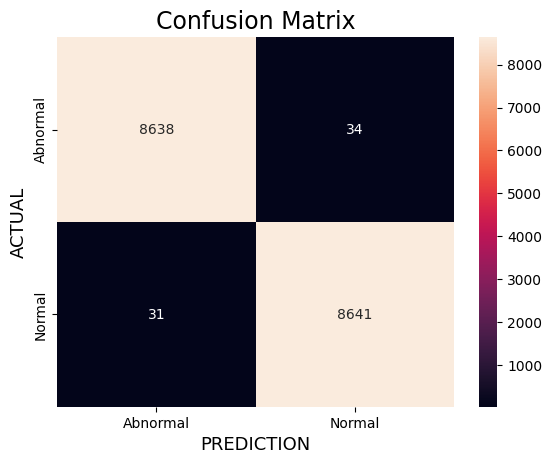

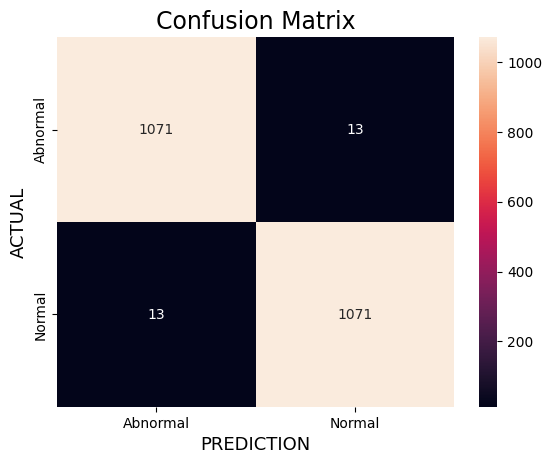

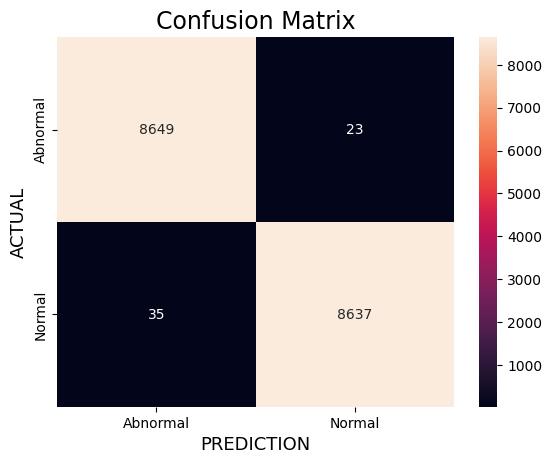

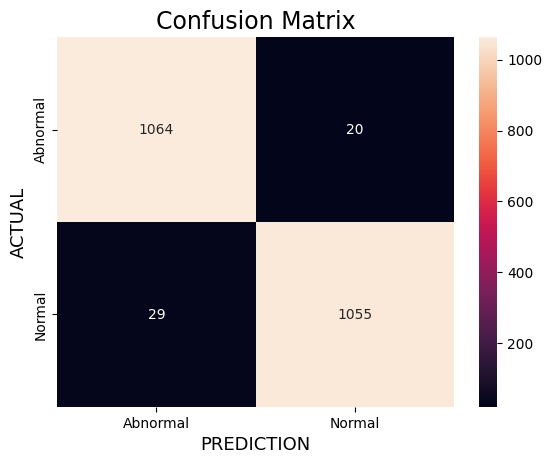

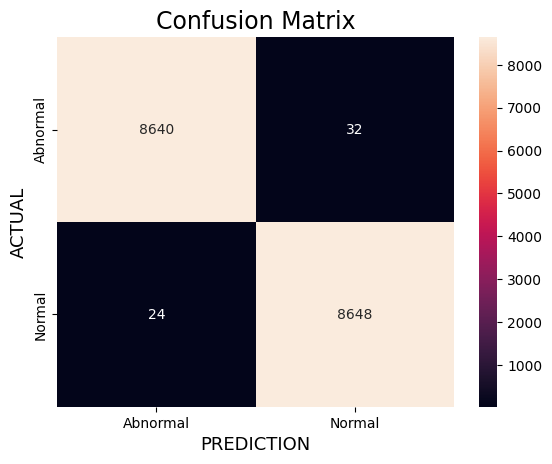

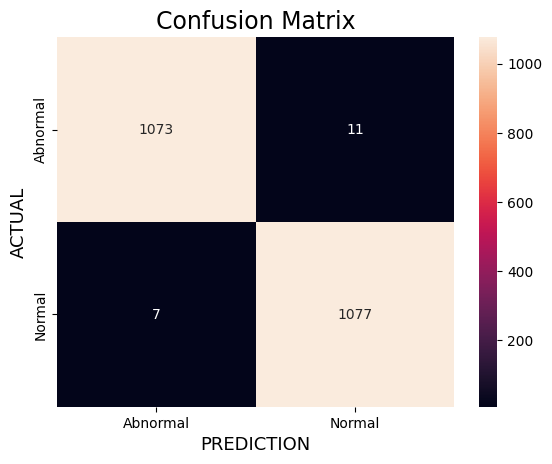

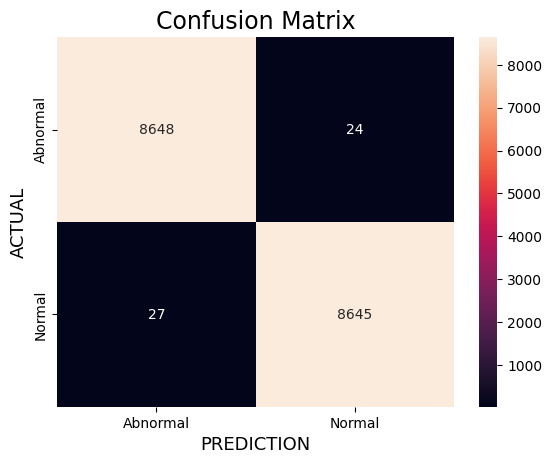

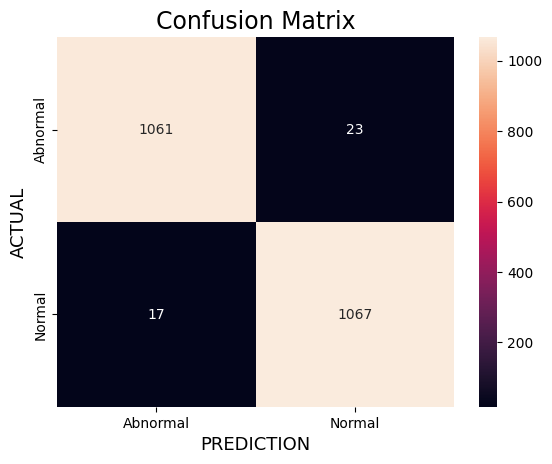

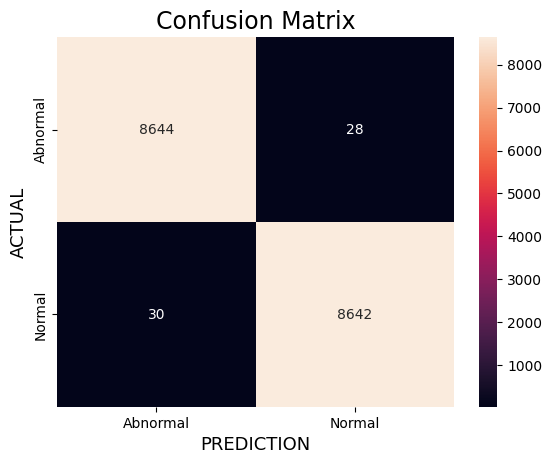

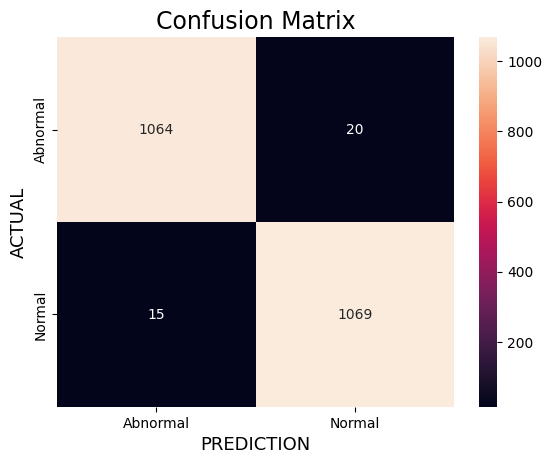

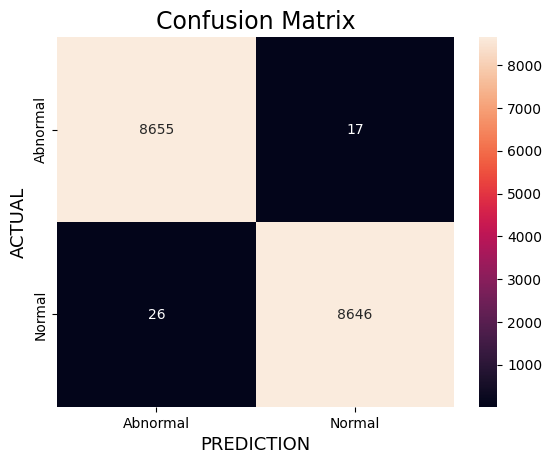

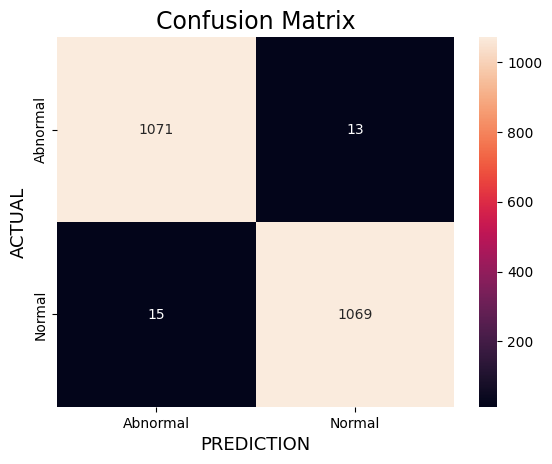

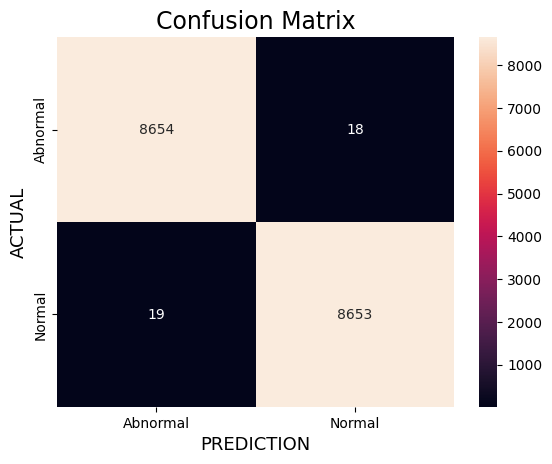

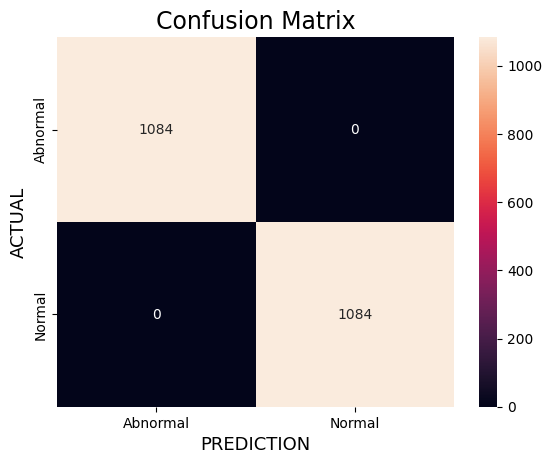

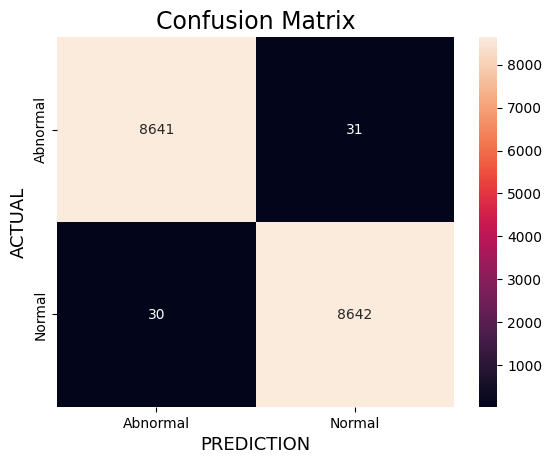

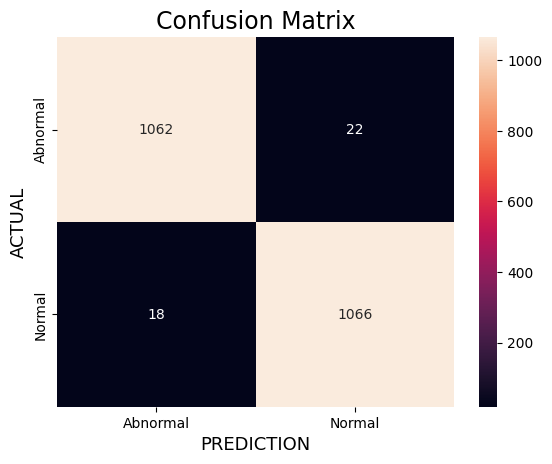

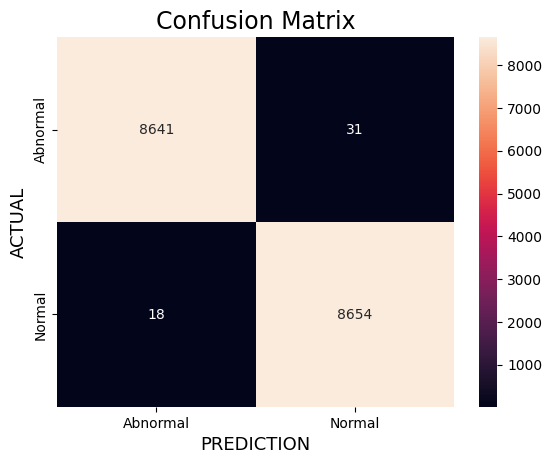

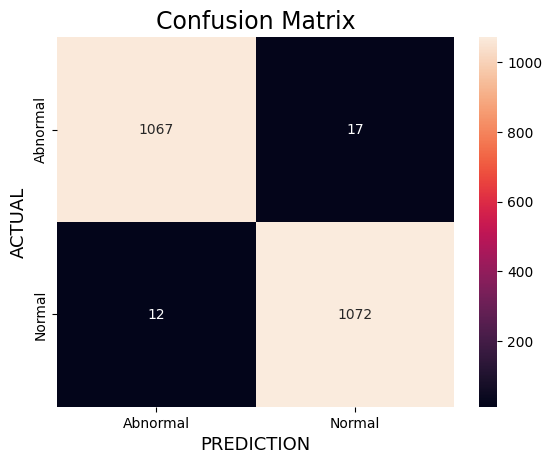

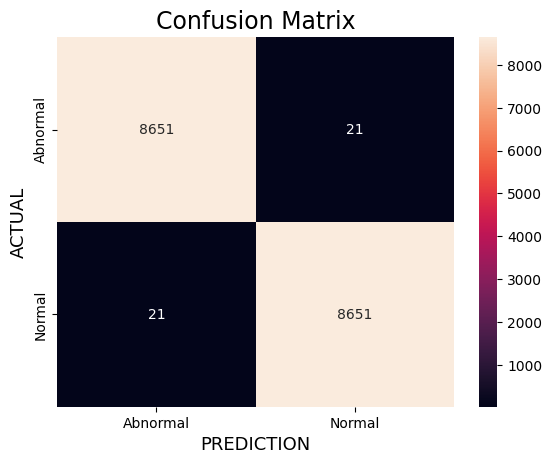

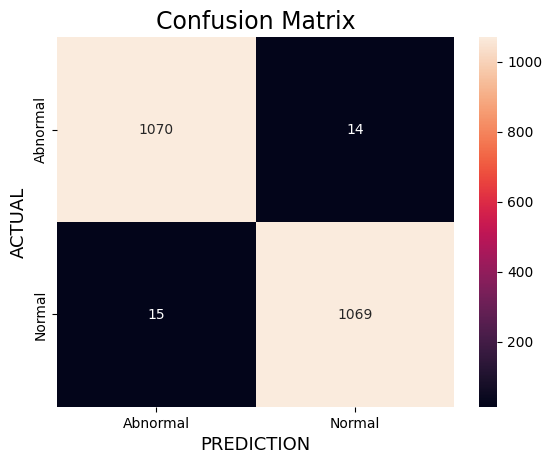

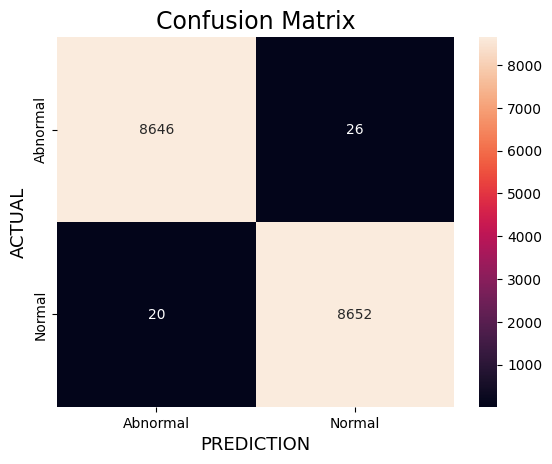

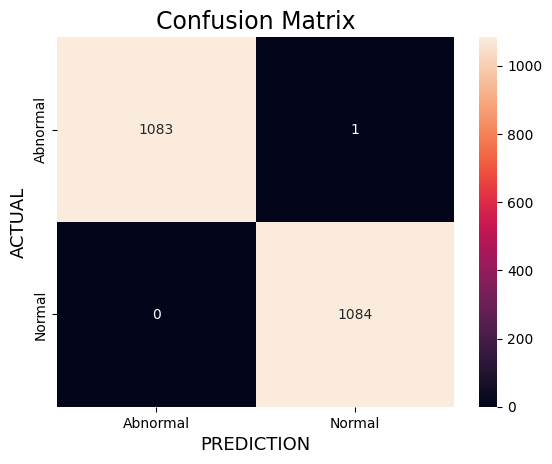

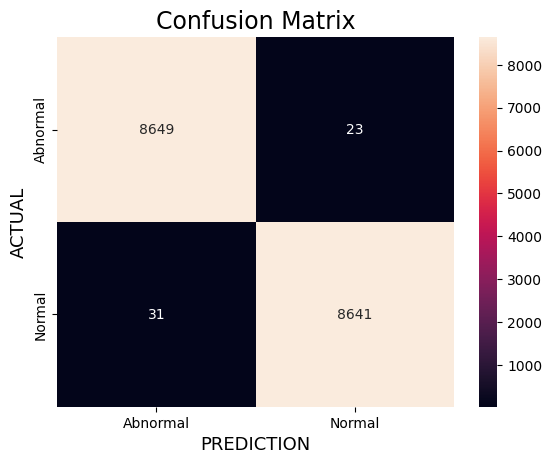

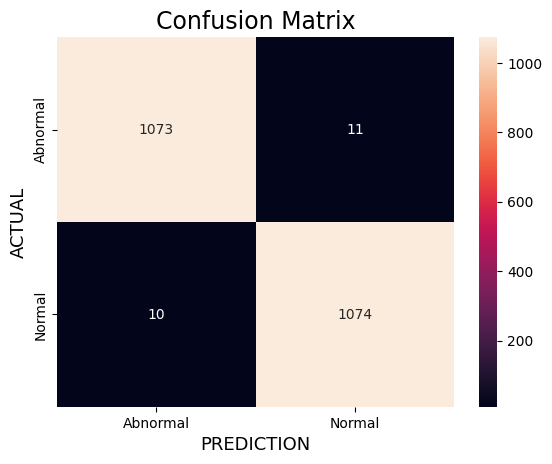

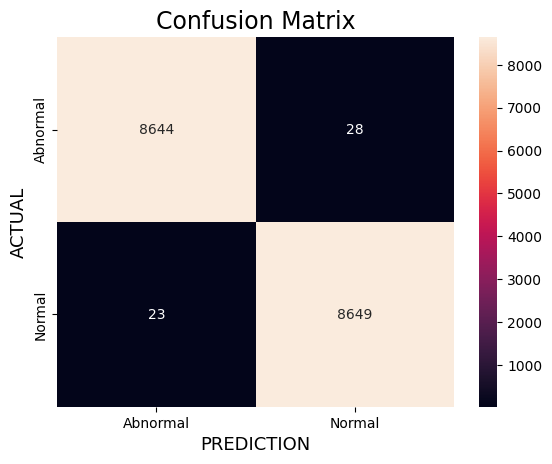

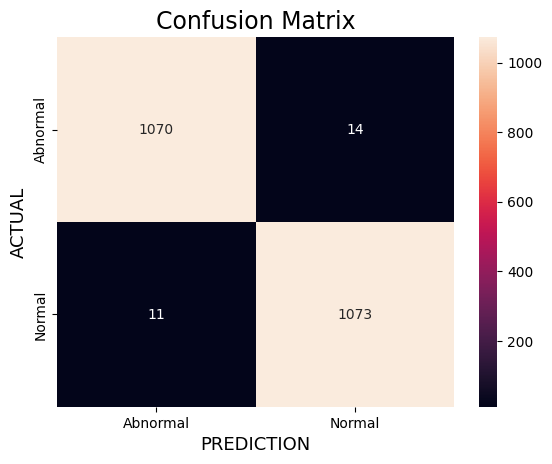

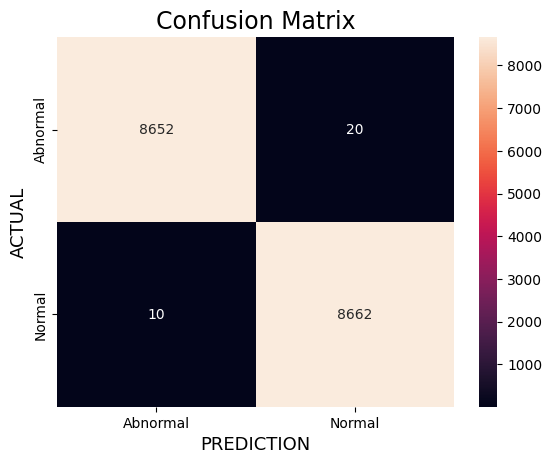

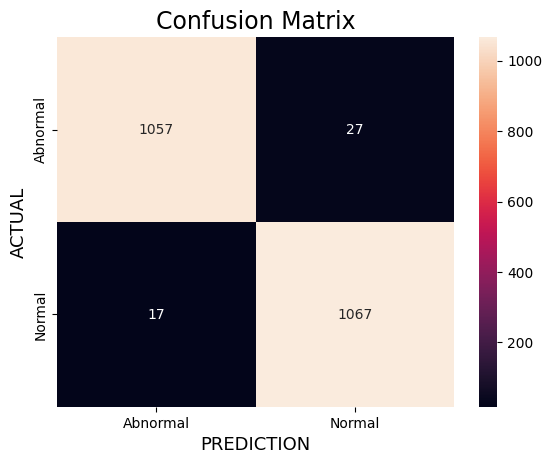

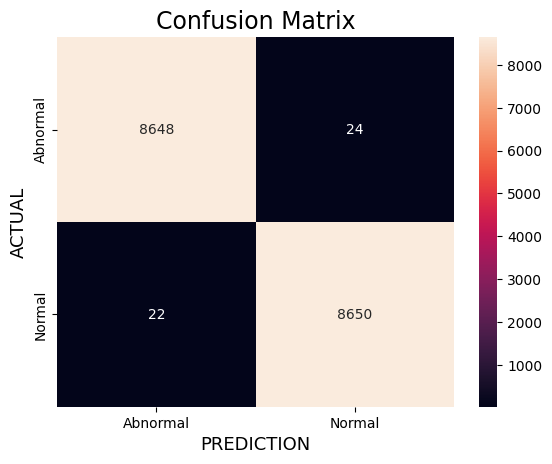

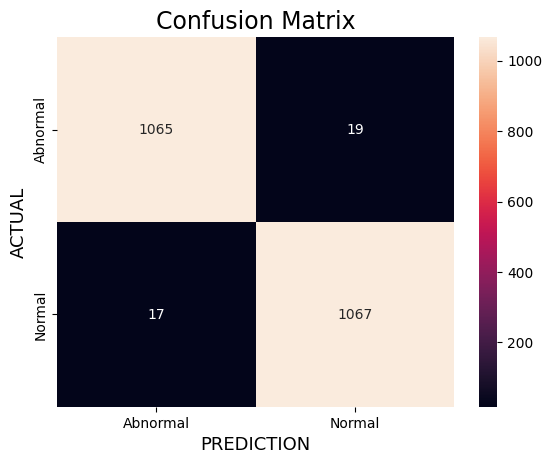

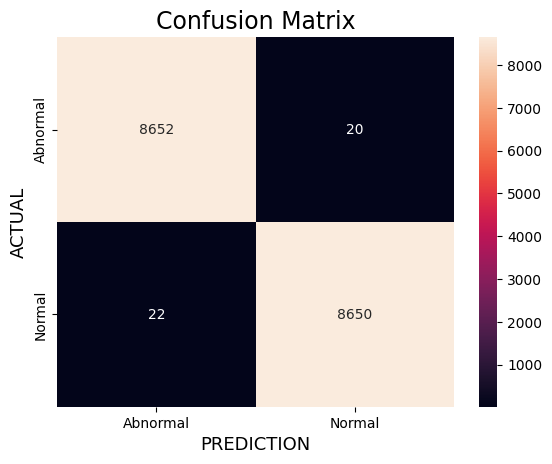

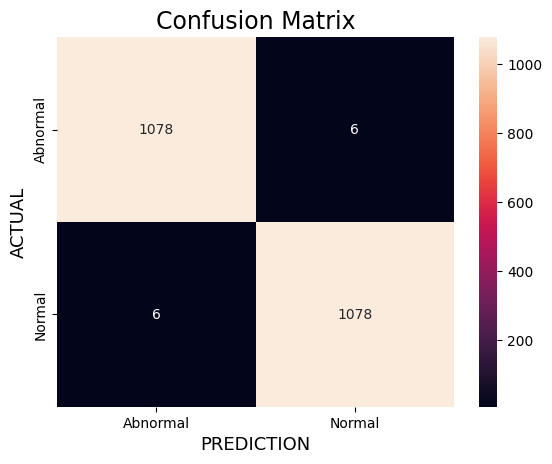

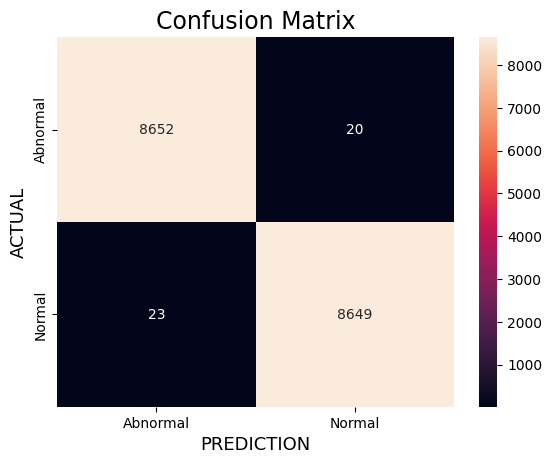

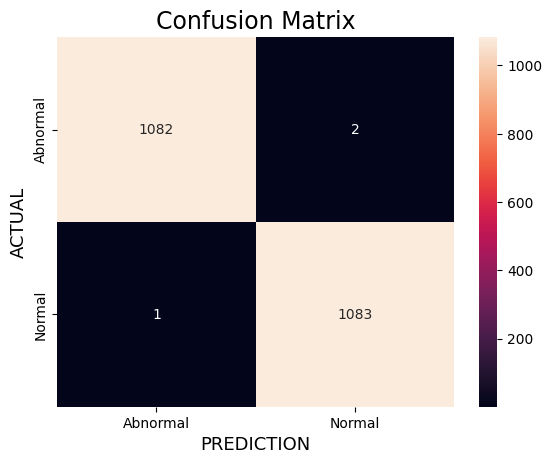

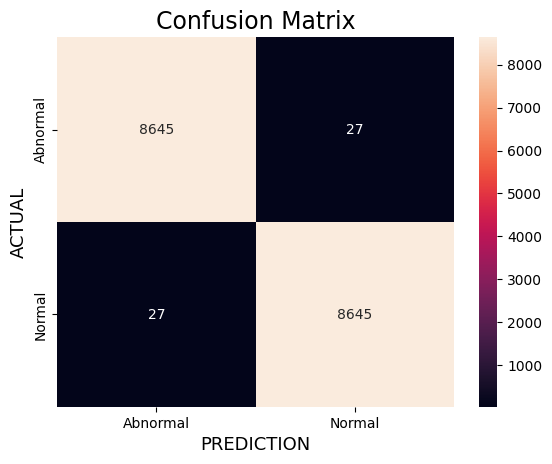

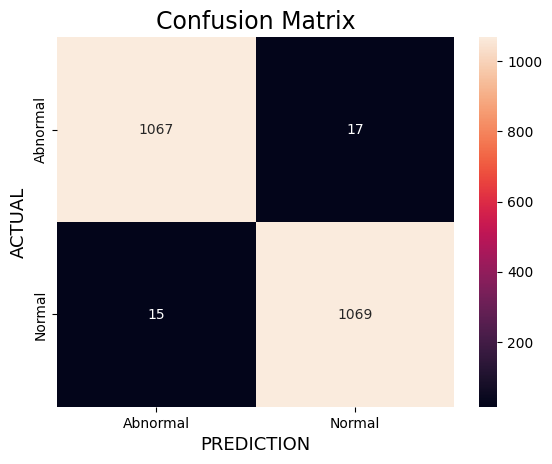

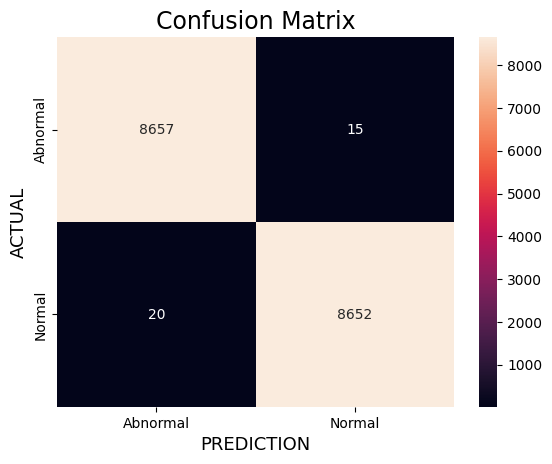

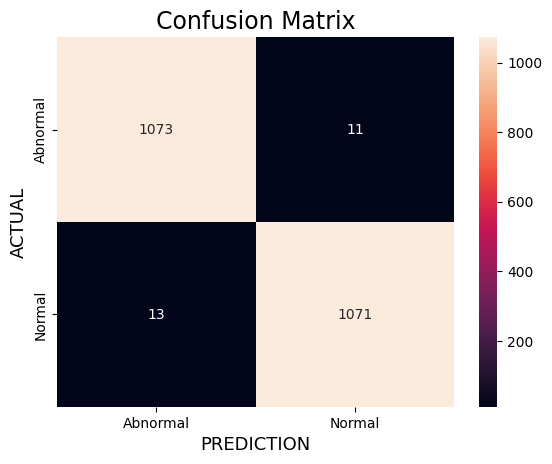

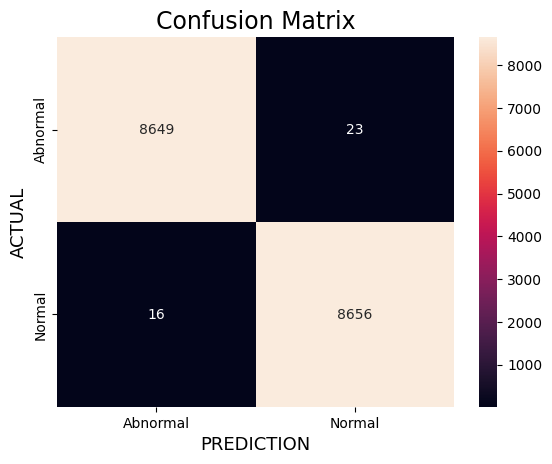

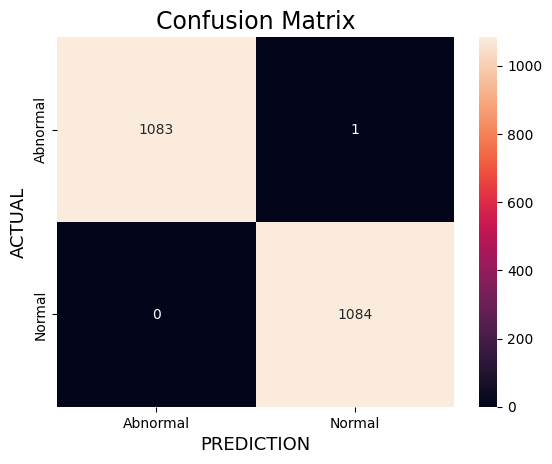

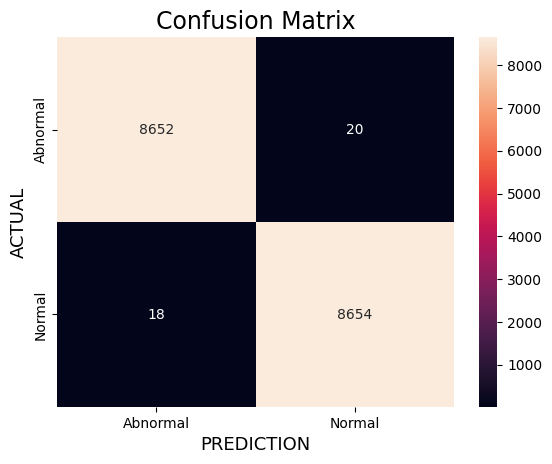

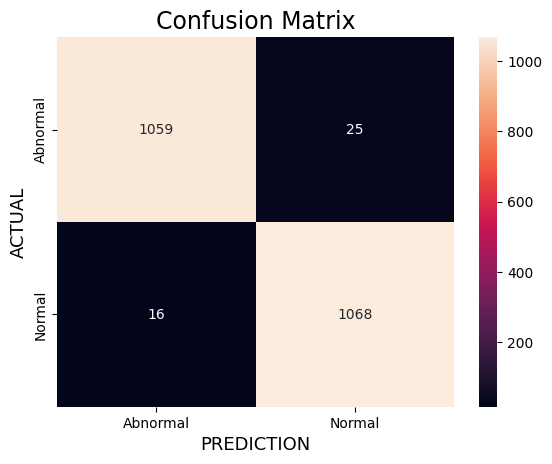

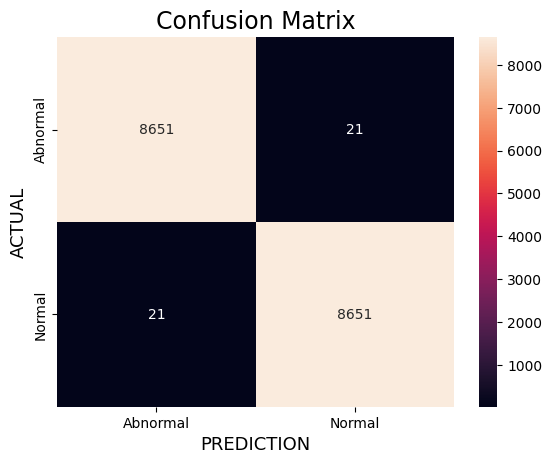

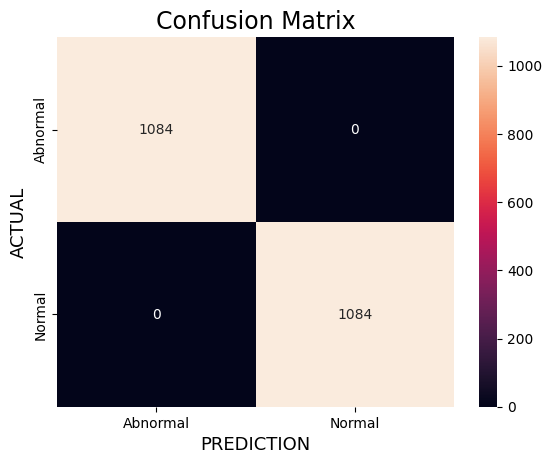

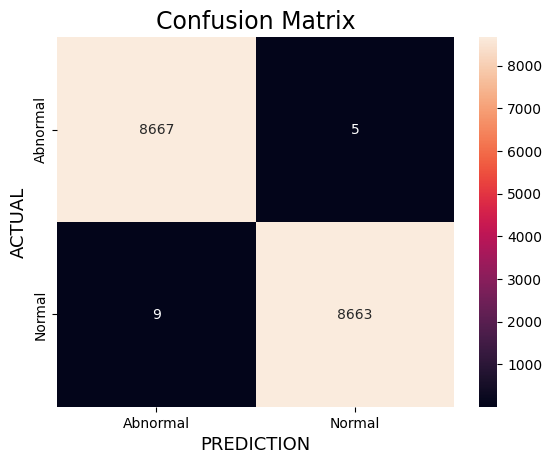

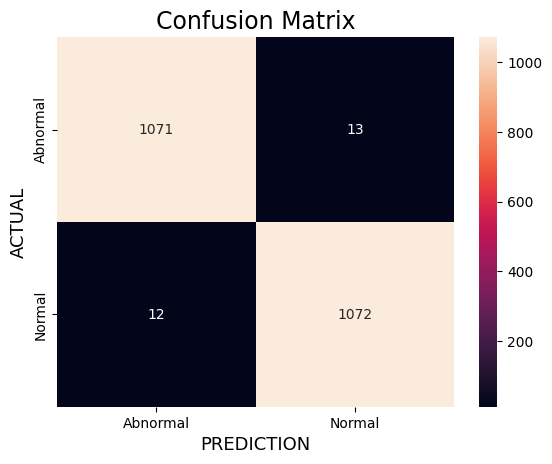

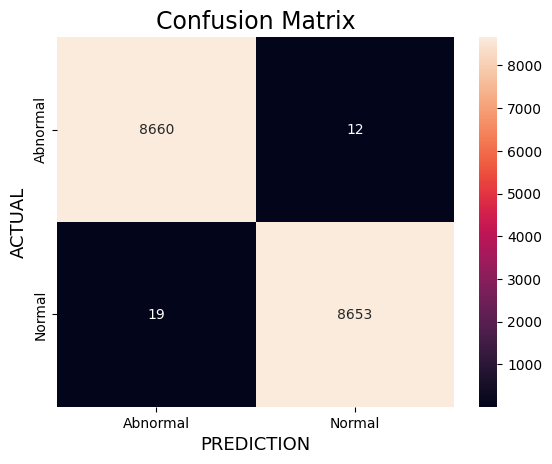

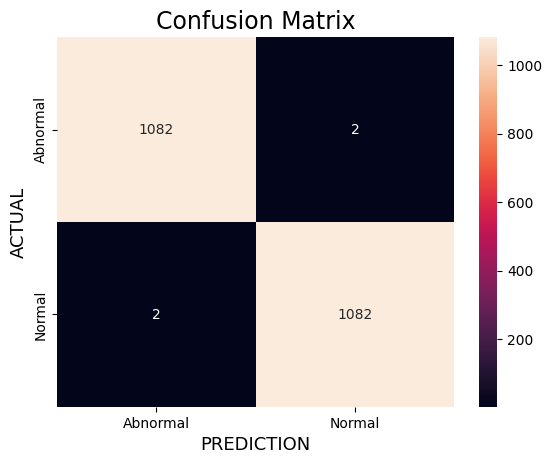

In [32]:
cm_dir = path_model + "/Confusion Matrix"
train_cm_dir = cm_dir + "/Train"
val_cm_dir = cm_dir + "/Val"

try:
    os.mkdir(cm_dir)
    os.mkdir(train_cm_dir)
    os.mkdir(val_cm_dir)
except:
    pass


for i in range(len(result_value['train_acc'])):
    train_cm_cd = train_cm_dir + f'/Train_CM_Epoch{i+1}'
    os.mkdir(train_cm_cd)
    plot_confusion_matrix(result_value["train_cm"][i], class_names, train_cm_cd, f"Confusion_Matrix_Train_{i+1}")
    
    val_cm_cd = val_cm_dir + f'/Validate_CM_Epoch{i+1}'
    os.mkdir(val_cm_cd)
    plot_confusion_matrix(result_value["val_cm"][i], class_names, val_cm_cd, f"Confusion_Matrix_Val_{i+1}")

<h3>Confusion Matrix for Best Value (Training and Validation)</h3>

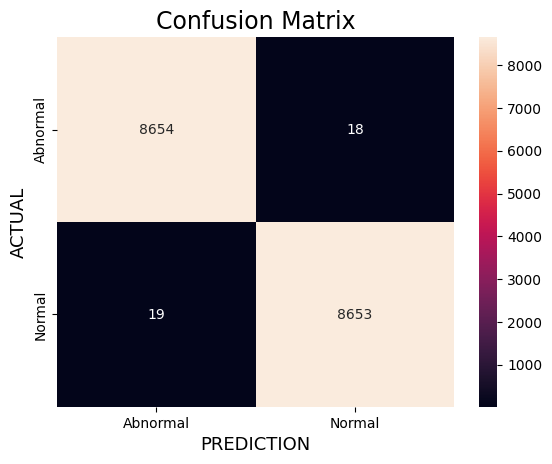

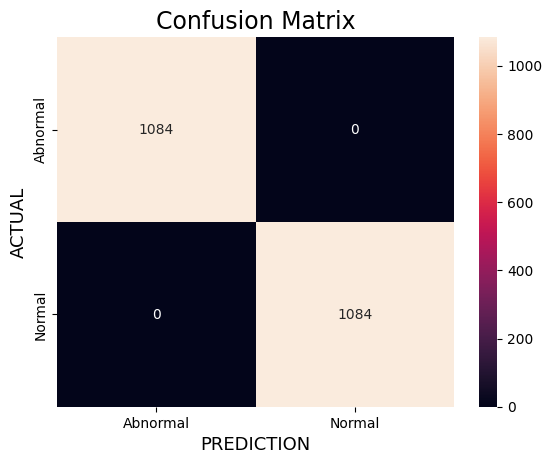

In [33]:
plot_confusion_matrix(result_value['train_cm'][best_num_epoch], class_names, path_model, f"Confusion_Matrix_Best_State_Train_{model_name}")
plot_confusion_matrix(result_value['val_cm'][best_num_epoch], class_names, path_model, f"Confusion_Matrix_Best_State_Val_{model_name}")

<h3>Report Evaluate Scoring (Training and Validation)</h3>

In [34]:
dt_string = now.strftime("%Y%m%d_%H%M%S")
f= open(f"{path_model}/report_train_acc_loss_model_{dt_string}.txt","w+")

dt_string = now.strftime("%Y/%m/%d %H:%M:%S")

# loss = result_value["train_loss"]
# val_loss = result_value["val_loss"]

# accuracy = result_value["train_acc"]
# val_accuracy = result_value["val_acc"]

train_recall = result_value["train_recall"]
train_precision = result_value["train_precision"]
train_specificity = result_value["train_specificity"]
train_f1_score = result_value["train_f1_score"]
train_loss = result_value["train_loss"]
train_acc = result_value["train_acc"]
val_recall = result_value["val_recall"]
val_precision = result_value["val_precision"]
val_specificity = result_value["val_specificity"]
val_f1_score = result_value["val_f1_score"]
val_loss = result_value["val_loss"]
val_acc = result_value["val_acc"]

f.write(f"[{model_name}]\n\n")
f.write(f"Epochs : {len(train_recall)}\n")
f.write(f"Criterion (Loss) : {criterion}\n")
f.write(f"Optimizer : {optimizer_ft}\n\n")
f.write(f"[Report Train and Validation Accuracy / Loss ({dt_string})]\n\n")

for i in range(len(train_recall)):
     f.write("Epoch {} result: \n".format(i + 1))
     f.write('-' * 10 + "\n")

     # f.write("Avg loss (train): {:.4f}\n".format(loss[i]))
     # f.write("Avg acc (train): {:.4f}\n".format(accuracy[i]))
     # f.write("Avg loss (val): {:.4f}\n".format(val_loss[i]))
     # f.write("Avg acc (val): {:.4f}\n".format(val_accuracy[i]))

     f.write("Sensitivity (Recall) (train): {:.4f}\n".format(train_recall[i]))
     f.write("Precision (train): {:.4f}\n".format(train_precision[i]))
     f.write("Specificity (train): {:.4f}\n".format(train_specificity[i]))
     f.write("F1 Score (train): {:.4f}\n".format(train_f1_score[i]))
     f.write("Avg Loss (train): {:.4f}\n".format(train_loss[i]))
     f.write("ACCURACY (train): {:.4f}\n\n".format(train_acc[i]))
     
     f.write("Sensitivity (Recall) (val): {:.4f}\n".format(val_recall[i]))
     f.write("Precision (val): {:.4f}\n".format(val_precision[i]))
     f.write("Specificity (val): {:.4f}\n".format(val_specificity[i]))
     f.write("F1 Score (val): {:.4f}\n".format(val_f1_score[i]))
     f.write("Avg Loss (val): {:.4f}\n".format(val_loss[i]))
     f.write("ACCURACY (val): {:.4f}\n".format(val_acc[i]))
     f.write('-' * 10 + "\n\n")

f.close()

In [35]:
f= open(f"{path_model}/report_best_state_{model_name}.txt","w+")

train_recall = result_value["train_recall"][best_num_epoch]
train_precision = result_value["train_precision"][best_num_epoch]
train_specificity = result_value["train_specificity"][best_num_epoch]
train_f1_score = result_value["train_f1_score"][best_num_epoch]
train_loss = result_value["train_loss"][best_num_epoch]
train_acc = result_value["train_acc"][best_num_epoch]

val_recall = result_value["val_recall"][best_num_epoch]
val_precision = result_value["val_precision"][best_num_epoch]
val_specificity = result_value["val_specificity"][best_num_epoch]
val_f1_score = result_value["val_f1_score"][best_num_epoch]
val_loss = result_value["val_loss"][best_num_epoch]
val_acc = result_value["val_acc"][best_num_epoch]

f.write(f"[{model_name}]\n\n")
f.write(f"Epochs : {epochs}\n")
f.write(f"Criterion (Loss) : {criterion}\n")
f.write(f"[Report Best Accuracy for Select State by Validation Dataset]\n\n")

f.write(f"Best Epoch to Select State Dict: {best_num_epoch + 1}\n")
f.write(f"Target Best Value : {select_best_value}\n\n")

f.write("Sensitivity (Recall) (train): {:.4f}\n".format(train_recall))
f.write("Precision (train): {:.4f}\n".format(train_precision))
f.write("Specificity (train): {:.4f}\n".format(train_specificity))
f.write("F1 Score (train): {:.4f}\n".format(train_f1_score))
f.write("Avg Loss (train): {:.4f}\n".format(train_loss))
f.write("ACCURACY (train): {:.4f}\n\n".format(train_acc))

f.write("Sensitivity (Recall) (val): {:.4f}\n".format(val_recall))
f.write("Precision (val): {:.4f}\n".format(val_precision))
f.write("Specificity (val): {:.4f}\n".format(val_specificity))
f.write("F1 Score (val): {:.4f}\n".format(val_f1_score))
f.write("Avg Loss (val): {:.4f}\n".format(val_loss))
f.write("ACCURACY (val): {:.4f}\n".format(val_acc))

f.close()

<h2>Evaluate Model</h2>

<h3>1. Load Model (for VGG16 Model)</h3>

In [36]:
if select_model == "VGG16":

    input_model = torch.load(f"{path_model}/{model_name}.pt")
    # input_model = torch.load(f"./Result/VGG16_model_20230927_132251/VGG16_Norm_Abnorm_GastrointestinalTract_Model_20230927_132251.pt")
    model = models.vgg16_bn()
    model.load_state_dict(torch.load(sys_dir + "checkpoints/checkpoints/vgg16_bn-6c64b313.pth"))
    if use_gpu:
        model = model.to(device)
        
    # Fix key mismatch
#     state_dict = {k.replace('module.', ''): v for k, v in input_model['model_state_dict'].items()}

    # Newly created modules have require_grad=True by default
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
    model.classifier = nn.Sequential(*features) # Replace the model classifier

    if torch.cuda.is_available():
        if num_gpus > 1:
        #         print(f'Number of available GPUs: {num_gpus}')
                # นำรหัสไปและวงล้อรอบโมเดลด้วย DataParallel
                model = nn.DataParallel(model)
        model = model.cuda()

    model.load_state_dict(input_model['model_state_dict'])
    optimizer_ft.load_state_dict(input_model['optimizer_state_dict'])

    epochs = input_model['epoch']
    criterion = input_model['loss']
    result_acc_loss = input_model['result_acc_loss']

<h3>1. Load Model (for ViT Model)</h3>

In [37]:
if select_model == "ViT":

    from collections import OrderedDict
    input_model = torch.load(f"{path_model}/{model_name}.pt")
    # input_model = torch.load(f"./Result/Model/VGG16_Norm_Abnorm_GastrointestinalTract_Model_20230913_145904.pt")
    model = models.vit_b_16()
    model.load_state_dict(torch.load(sys_dir + "checkpoints/checkpoints/vit_b_16-c867db91.pth"))
    if use_gpu:
        model = model.to(device)

    # # Newly created modules have require_grad=True by default
    num_features = model.heads[0].in_features
    features = list(model.heads.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
    model.heads = nn.Sequential(OrderedDict([('head', *features)])) # Replace the model classifier
    print(model)

    if torch.cuda.is_available():
        if num_gpus > 1:
        #         print(f'Number of available GPUs: {num_gpus}')
                # นำรหัสไปและวงล้อรอบโมเดลด้วย DataParallel
                model = nn.DataParallel(model)
        model = model.cuda()

    model.load_state_dict(input_model['model_state_dict'])
    # optimizer_ft.load_state_dict(input_model['optimizer_state_dict'])

    epochs = input_model['epoch']
    criterion = input_model['loss']
    result_acc_loss = input_model['result_acc_loss']

<h3>2. Evaluate and Get Result</h3>

In [38]:
from model_classification_func import train_model, resume_train_model, eval_model, visualize_model

result_value_test, confusion_matrix, y_proba, y_truth, correct_pred_imgs, incorrect_pred_imgs = eval_model(model, criterion, class_names, test_dl, test_data, device, use_gpu)

Evaluating model
----------
Test batch 67/68 (98.53%)
Evaluation completed in 0m 30s
Sensitivity (Recall) (test): 0.9742
Precision (test): 0.9395
Specificity (test): 0.9373
F1 Score (test): 0.9565
Avg Loss (test): 0.0112
ACCURACY (test): 0.9557
----------


In [39]:
dt_string = now.strftime("%Y%m%d_%H%M%S")
f= open(f"{path_model}/report_model_evaluation_{dt_string}.txt","w+")

dt_string = now.strftime("%Y/%m/%d %H:%M:%S")

# loss = result_value_test["test_loss"]
# accuracy = result_value_test["test_acc"]

test_recall = result_value_test["test_recall"]
test_precision = result_value_test["test_precision"]
test_specificity = result_value_test["test_specificity"]
test_f1_score = result_value_test["test_f1_score"]
test_loss = result_value_test["test_loss"]
test_acc = result_value_test["test_acc"]

f.write(f"[{model_name}]\n\n")
f.write(f"Epochs : {input_model['epoch']}\n")
f.write(f"Criterion (Loss) : {criterion}\n")
f.write(f"Optimizer : {optimizer_ft}\n\n")
f.write(f"[Report Model Evaluation by Test Dataset ({dt_string})]\n\n")

for i in range(len(test_recall)):
    f.write("Sensitivity (Recall) (test): {:.4f}\n".format(test_recall[i]))
    f.write("Precision (test): {:.4f}\n".format(test_precision[i]))
    f.write("Specificity (test): {:.4f}\n".format(test_specificity[i]))
    f.write("F1 Score (test): {:.4f}\n".format(test_f1_score[i]))
    f.write("Avg Loss (test): {:.4f}\n".format(test_loss[i]))
    f.write("ACCURACY (test): {:.4f}\n".format(test_acc[i]))

# for i in range(len(loss)):
#      f.write("Epoch {} result: \n".format(i + 1))
#      f.write('-' * 10 + "\n")
#      f.write("Avg loss (train): {:.4f}\n".format(loss[i]))
#      f.write("Avg acc (train): {:.4f}\n".format(accuracy[i]))
#      f.write("Avg loss (val): {:.4f}\n".format(val_loss[i]))
#      f.write("Avg acc (val): {:.4f}\n".format(val_accuracy[i]))
#      f.write('-' * 10 + "\n\n")

f.close()

<h3>3. Visualize for Model Prediction</h3>

Ground truth:


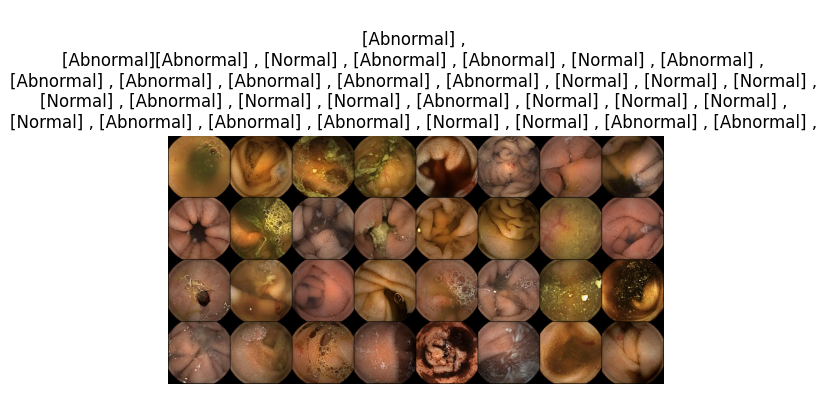

Prediction:


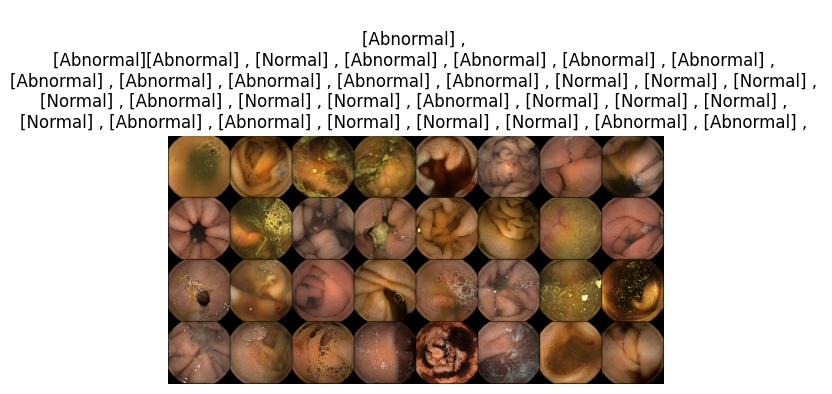

In [40]:
visualize_model(model, test_dl, class_names, use_gpu, num_images=32)

<h3>4. Test Predict</h3>

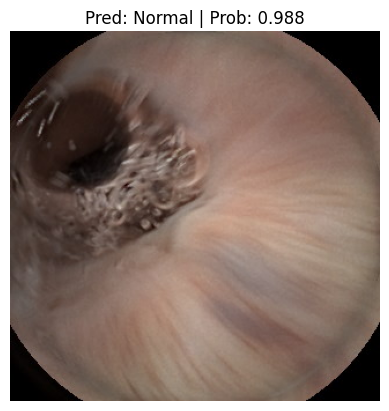

In [41]:
pred_and_plot_image(model=model, image_path= sys_dir + "image-00026.png", device = device, class_names = class_names)

<h3>5. Confusion Matrix</h3>

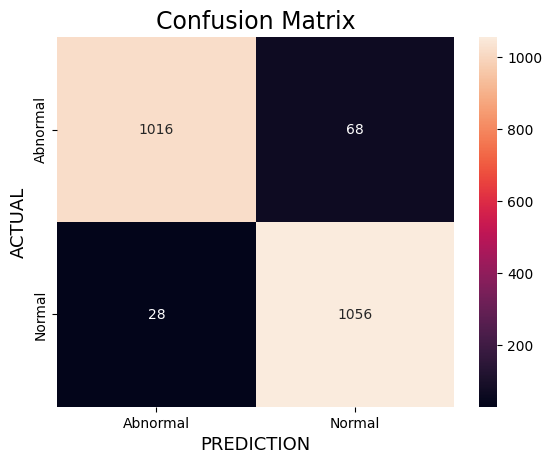

In [42]:
plot_confusion_matrix(confusion_matrix, class_names, path_model, f"Confusion_Matrix_Test_{now.strftime('%Y%m%d_%H%M%S')}")

<h3>6. ROC Curve</h3>

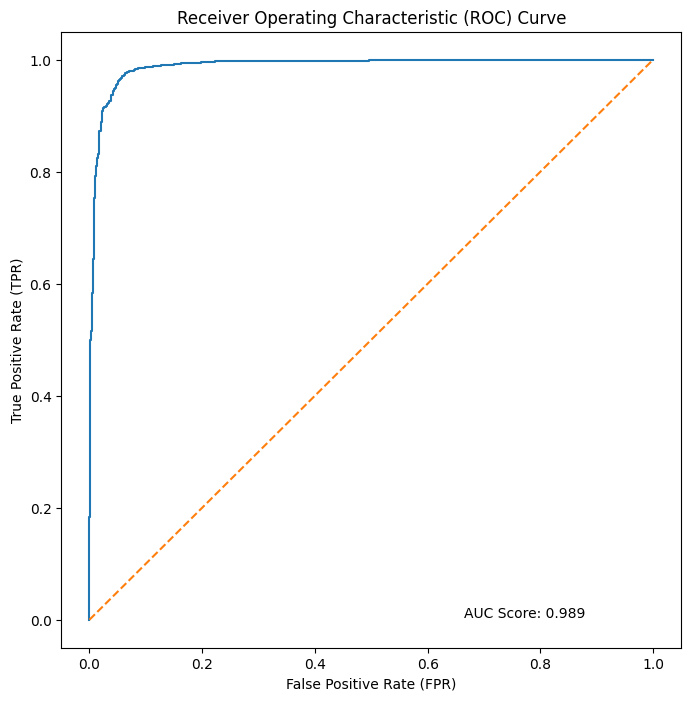

In [43]:
plot_ROCAUC_curve(y_truth, y_proba, (8, 8), now, path_model)

<h3>7. Report Dataset Directory</h3>

In [44]:
train_imgs = [dataset.imgs[i_] for i_ in train_indices]
valid_imgs = [dataset.imgs[i_] for i_ in validation_indices]
test_imgs = [dataset.imgs[i_] for i_ in test_indices]

dt_string = now.strftime("%Y%m%d_%H%M%S")

f= open(f"{path_model}/report_dataset_directory_{dt_string}.txt","w+")

f.write(f"[{model_name}]\n\n")
f.write(f"Epochs : {epochs}\n")
f.write(f"Criterion (Loss) : {criterion}\n")
f.write(f"Optimizer : {optimizer_ft}\n\n")

dt_string = now.strftime("%Y/%m/%d %H:%M:%S")

f.write(f"[Dataset Report ({dt_string})]\n\n")
f.write(f"Image Resolution (W x H) : {img_size}\n")
f.write(f"Batch Size : {batch_size}\n")
f.write(f"Seed Number : {seed_number}\n")
f.write(f"Train Size : {train_size} , Validate Size : {val_size} , Test Size : {test_size}\n\n")
f.write("[Train Dataset]\n\n")

for i in range(len(train_imgs)):
     f.write(str(train_imgs[i]) + "\n")

f.write("\n[Validate Dataset]\n\n")

for i in range(len(valid_imgs)):
     f.write(str(valid_imgs[i]) + "\n")

f.write("\n[Test Dataset]\n\n")

for i in range(len(test_imgs)):
     f.write(str(test_imgs[i]) + "\n")

f.close()

<h3>8. Grad-CAM</h3>

In [45]:
def pred_and_plot_image_before_grad_cam(
    model: torch.nn.Module,
    class_names: List[str],
    image_tensor: torch.Tensor,
    device: torch.device,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = image_tensor

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        # transformed_image = image_transform(img).unsqueeze(dim=0)
        transformed_image = img

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.subplot(2, 2, 2)

    plt.title("Probability of Model Prediction", fontsize = 16)
    plt.bar(class_names, target_image_pred_probs.cpu().numpy()[0])
    plt.grid(True)
    plt.axis(True)

    return target_image_pred_probs, target_image_pred_label

In [46]:
model_report_correct_grad_path = f"{path_model}/Report_Correct_GradCam"

if not os.path.exists(model_report_correct_grad_path):
    try:
        # สร้างโฟลเดอร์
        os.makedirs(model_report_correct_grad_path)
        print("โฟลเดอร์ถูกสร้างแล้ว")
    except OSError as e:
        print(f"การสร้างโฟลเดอร์ล้มเหลว: {e}")
else:
    print("โฟลเดอร์มีอยู่แล้ว")
    
model_report_incorrect_grad_path = f"{path_model}/Report_Incorrect_GradCam"

if not os.path.exists(model_report_incorrect_grad_path):
    try:
        # สร้างโฟลเดอร์
        os.makedirs(model_report_incorrect_grad_path)
        print("โฟลเดอร์ถูกสร้างแล้ว")
    except OSError as e:
        print(f"การสร้างโฟลเดอร์ล้มเหลว: {e}")
else:
    print("โฟลเดอร์มีอยู่แล้ว")

โฟลเดอร์ถูกสร้างแล้ว
โฟลเดอร์ถูกสร้างแล้ว


In [47]:
if select_model == "VGG16":
    class_target_count = len(model.module.classifier[-1].state_dict()) # For VGG16 Model
elif select_model == "ViT":
    class_target_count = len(model.module.heads._modules['head'].state_dict()) # For ViT Model
else:
    sys.exit()

# For ViT Model
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Change Model Device
model.to(device)

model.train(False)
model.eval()

# Construct the CAM object once, and then re-use it on many images:
if select_model == "VGG16":
    target_layers = [model.module.features[-1]] # VGG16 Model
elif select_model == "ViT":
    target_layers = [model.module.encoder.layers[-1]._modules['ln_1']] # ViT Model
else:
    sys.exit()

def class_idx_to_name(class_idx):
    if class_idx == 0:
        return "Abnormal"
    else:
        return "Normal"    

def grad_cam_for_eval_output(pred_imgs_list: List, correct_pred: bool):
    for idx in tqdm(range(len(pred_imgs_list))):

        with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform if select_model == "ViT" else None) as cam: 

            input_tensor = pred_imgs_list[idx]

            plt.figure(figsize=(15, 15))

            plt.subplot(2, 2, 1)
            plt.title(f'Original Image\nPredicted : {class_idx_to_name(input_tensor[1].cpu().numpy())}\nGround truth : {class_idx_to_name(input_tensor[2].cpu().numpy())}', fontsize = 14)
            plt.imshow(input_tensor[0].permute(1, 2, 0).cpu().numpy())

            prob, pred_label = pred_and_plot_image_before_grad_cam(model=model, class_names=['Abnormal', 'Normal'], image_tensor=input_tensor[0].unsqueeze(0).to(device), device=device)

            for i in range(class_target_count):
                targets = [ClassifierOutputTarget(i)]

                grayscale_cam = cam(input_tensor=input_tensor[0].unsqueeze(0).to(device), targets=targets)

                img_rgb = input_tensor[0].permute(1, 2, 0).cpu().numpy()
                img_rgb_norm = (img_rgb-np.min(img_rgb))/(np.max(img_rgb)-np.min(img_rgb))

                grayscale_cam = grayscale_cam[0, :]

                visualization = show_cam_on_image(img_rgb_norm, grayscale_cam, use_rgb=True)

                plt.subplot(2, 2, i+3)
                plt.title(f'Grad-CAM : {class_idx_to_name(i)}', fontsize = 18)
                plt.imshow(visualization)

                del img_rgb, img_rgb_norm, visualization
                torch.cuda.empty_cache()

            if correct_pred:    
                plt.savefig(f"{model_report_correct_grad_path}/report_correct_grad_cam_visualize_{idx}.jpg")
            else:
                plt.savefig(f"{model_report_incorrect_grad_path}/report_incorrect_grad_cam_visualize_{idx}.jpg")

            plt.close()

            del cam, grayscale_cam, input_tensor, 
            torch.cuda.empty_cache()

    print("GradCAM Operation Successfully")


In [48]:
grad_cam_for_eval_output(pred_imgs_list=correct_pred_imgs, correct_pred=True)
grad_cam_for_eval_output(pred_imgs_list=incorrect_pred_imgs, correct_pred=False)

100%|██████████| 2072/2072 [31:38<00:00,  1.09it/s]


GradCAM Operation Successfully


100%|██████████| 96/96 [01:30<00:00,  1.06it/s]

GradCAM Operation Successfully
